# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const
import time
import astropy.units as u

import os,sys
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('Research')
save_path_idx = splt_path.index('DetectorDesignSensitivities')
save_directory = "/".join(splt_path[0:save_path_idx+1])
top_directory = "/".join(splt_path[0:top_path_idx+1])

gwent_path = top_directory + '/gwent/'

sys.path.insert(0,gwent_path)
import gwent
from gwent import binary
from gwent import detector
from gwent import snr
from gwent import snrplot

Setting matplotlib preferences

In [4]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = False
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

We need to get the file directories to load in the instrument files.

In [5]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'
save_fig_location = gwent.__path__[0] + '/Figures/'
save_snr_location = os.getcwd() + '/saved_SNRs/'
print(save_snr_location)

/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/notebook_examples/saved_SNRs/


## Declaring x and y variables and Sample Rates

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* LISA ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IFO' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IFO_break' - The Optical Metrology Noise Break Frequency
    
* PTAs ONLY:

    * 'N_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

In [6]:
#Number of SNRMatrix rows
sampleRate_y = 10
#Number of SNRMatrix columns
sampleRate_x = 10

## Source Selection Function

Takes in a an instrument model that dictates reasonable mass ranges for the particular detector mass regime and instantiates a source with the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one only needs to set the minima and maxima of the selected SNR axes variables.

In [7]:
def Get_Source(model):
    if model in [0,1,2,3]:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model in [4,5,6,7,8,9,10,11,12]:
        #M = m1+m2 Total Mass
        M = 1e9
        M_min = 1e8
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 1.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

## Instrument Selection Function

Takes in an instrument model then assigns the fiducial noise and detector values. The model only assigns ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

For generating a detector, one must assign a value to each of the different instrument parameters (see the section on Declaring x and y variables and Sample Rates).

In [8]:
def Get_Instrument(model):
    if model in [0,1,2,3]:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        if model == 0: #Einstein Telescope
            #Loaded from http://www.et-gw.eu/index.php/etsensitivities
            load_name = 'ET_D_data.txt'
            load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
            instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        elif model == 1: #aLIGO
            noise_dict = {'Infrastructure':
                          {'Length':[3995,3000,5000]},
                          'Laser':
                          {'Power':[125,100,300]},
                          'Seismic':
                          {'Gamma':[0.8,0.1,1.0]}}
            instrument = detector.GroundBased('aLIGO',T_obs,noise_dict=noise_dict)
        elif model == 2: #Voyager
            noise_dict = {'Infrastructure':
                          {'Length':[3995,3000,5000]},
                          'Laser':
                          {'Power':[144.6848,100,300]},
                          'Seismic':
                          {'Gamma':[0.8,0.1,1.0]}}
            instrument = detector.GroundBased('Voyager',T_obs,noise_dict=noise_dict)
        elif model == 3: #Cosmic Explorer proposal 1
            noise_dict = {'Infrastructure':
                          {'Length':[40000,30000,50000]},
                          'Laser':
                          {'Power':[150,100,300]},
                          'Seismic':
                          {'Gamma':[0.8,0.1,1.0]}}
            instrument = detector.GroundBased('aLIGO gwinc',T_obs,noise_dict=noise_dict)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model in [4,5,6,7,8]:
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 11.4*u.yr #Observing time in years
        T_obs_min = 5*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        sigma_min = 100*u.ns.to('s')*u.s
        sigma_max = 500*u.ns.to('s')*u.s
        
        n_p = 18 #Number of pulsars
        n_p_min = 18
        n_p_max = 40
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        
        if model == 4: #NANOGrav 11.4 yr WN only
            instrument = detector.PTA('NANOGrav_WN',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence)
        elif model == 5: #NANOGrav 11.4 yr WN + RN
            instrument = detector.PTA('NANOGrav_WN_RN',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence,
                                      rn_amp=[1e-16,1e-12],rn_alpha=[-1/2,1.25])
        elif model == 6: #NANOGrav 11.4 yr WN + GWB
            instrument = detector.PTA('NANOGrav_WN_GWB',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence,
                                      GWB_amp=4e-16)
        elif model == 7: #NANOGrav realistic noise
            instrument = detector.PTA('NANOGrav_realistic_noise',n_p,use_11yr=True,use_rn=True)
        elif model == 8: #NANOGrav 11 yr real data
            #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
            load_name = 'NANOGrav_11yr_S_eff.txt'
            load_location = load_directory + 'NANOGrav/StrainFiles/' + load_name
            T_obs = 11.42*u.yr #Observing time in years
            instrument = detector.PTA('NANOGrav_11yr',load_location=load_location,I_type='E')
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.n_p = [n_p,n_p_min,n_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model in [9,10,11,12]: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        sigma_min = 10*u.ns.to('s')*u.s
        sigma_max = 100*u.ns.to('s')*u.s
        
        n_p = 20 #Number of pulsars
        n_p_min = 18
        n_p_max = 200
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        if model == 9: #SKA WN only
            instrument = detector.PTA('SKA_WN',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence)
        elif model == 10: #SKA WN + RN
            instrument = detector.PTA('SKA_WN_RN',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence,
                                      rn_amp=[1e-16,1e-12],rn_alpha=[-1/2,1.25])
        elif model == 11: #SKA WN + GWB
            instrument = detector.PTA('SKA_WN_GWB',n_p,T_obs=T_obs,sigma=sigma,cadence=cadence,
                                      GWB_amp=4e-16)
        elif model == 12: #SKA realistic noise
            T_realistic_SKA = np.concatenate((np.ones(34)*T_obs.value,
                                              np.random.uniform(3.,T_obs.value,size=(n_p-34))),
                                             axis=0)
            instrument = detector.PTA('SKA_realistic_noise',n_p,cadence=[cadence,cadence/4.],
                                      sigma=[sigma,10*sigma],T_obs=T_realistic_SKA,use_11yr=True,use_rn=True)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.n_p = [n_p,n_p_min,n_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model > 12:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        A_acc = 3e-15*u.m/u.s/u.s
        A_acc_min = 1e-16*u.m/u.s/u.s
        A_acc_max = 1e-14*u.m/u.s/u.s
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_min = .1*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_max = 1.0*u.mHz.to('Hz')*u.Hz
        
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_min = 1.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_max = 10.*u.mHz.to('Hz')*u.Hz
        
        f_IFO_break = 2.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_min = 1.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_max = 5.*u.mHz.to('Hz')*u.Hz
        
        A_IFO_min = 1.0e-12*u.m
        A_IFO_max = 2.0e-11*u.m
        
        if model == 13: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
            A_IFO = 1.5e-11*u.m
            Background = False
            T_type = 'A'

            instrument = detector.SpaceBased('Alt_LISA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)

        else: #L3 proposal
            #Default Params from https://arxiv.org/abs/1702.00786
            A_IFO = 10e-12*u.m
            Background = False
            T_type = 'N'
        
            instrument = detector.SpaceBased('LISA_ESA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        instrument.A_acc = [A_acc,A_acc_min,A_acc_max]
        instrument.f_acc_break_low = [f_acc_break_low,f_acc_break_low_min,f_acc_break_low_max]
        instrument.f_acc_break_high = [f_acc_break_high,f_acc_break_high_min,f_acc_break_high_max]
        instrument.A_IFO = [A_IFO,A_IFO_min,A_IFO_max]
        instrument.f_IFO_break = [f_IFO_break,f_IFO_break_min,f_IFO_break_max]
        
    return instrument

## SNR Calculation

Based on the selected model, we use `Get_Instrument` and `Get_Source` to instantiate both the instrument and the model for the SNR Calculation.

In [11]:
#Number of SNRMatrix rows
sampleRate_y = 10
#Number of SNRMatrix columns
sampleRate_x = 10
#Variable on y-axis
var_y = 'n_p'
#Variable on x-axis
var_x = 'M'
model = 7
instrument = Get_Instrument(model)
source = Get_Source(model)

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the `sampleRate1`X`sampleRate2`

In [21]:
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,var_x,sampleRate_x,var_y,sampleRate_y)
"""save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_SNR_v2.txt'
save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_v2.txt'

if var_y == 'N_p':
    save_sample_name_x = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_' + var_x + '_v2.txt'
    save_sample_name_y = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_' + var_y + '_v2.txt'
    np.savetxt(save_snr_location+save_sample_name_x,sample_x)
    np.savetxt(save_snr_location+save_sample_name_y,sample_y.astype(int))
    np.savetxt(save_snr_location+save_snr_name,SNRMatrix)
else:
    snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)"""

end = time.time()
print(end-start)

53.64973521232605


Plot the SNR using the initial variables and the returns from `Get_SNR_Matrix`

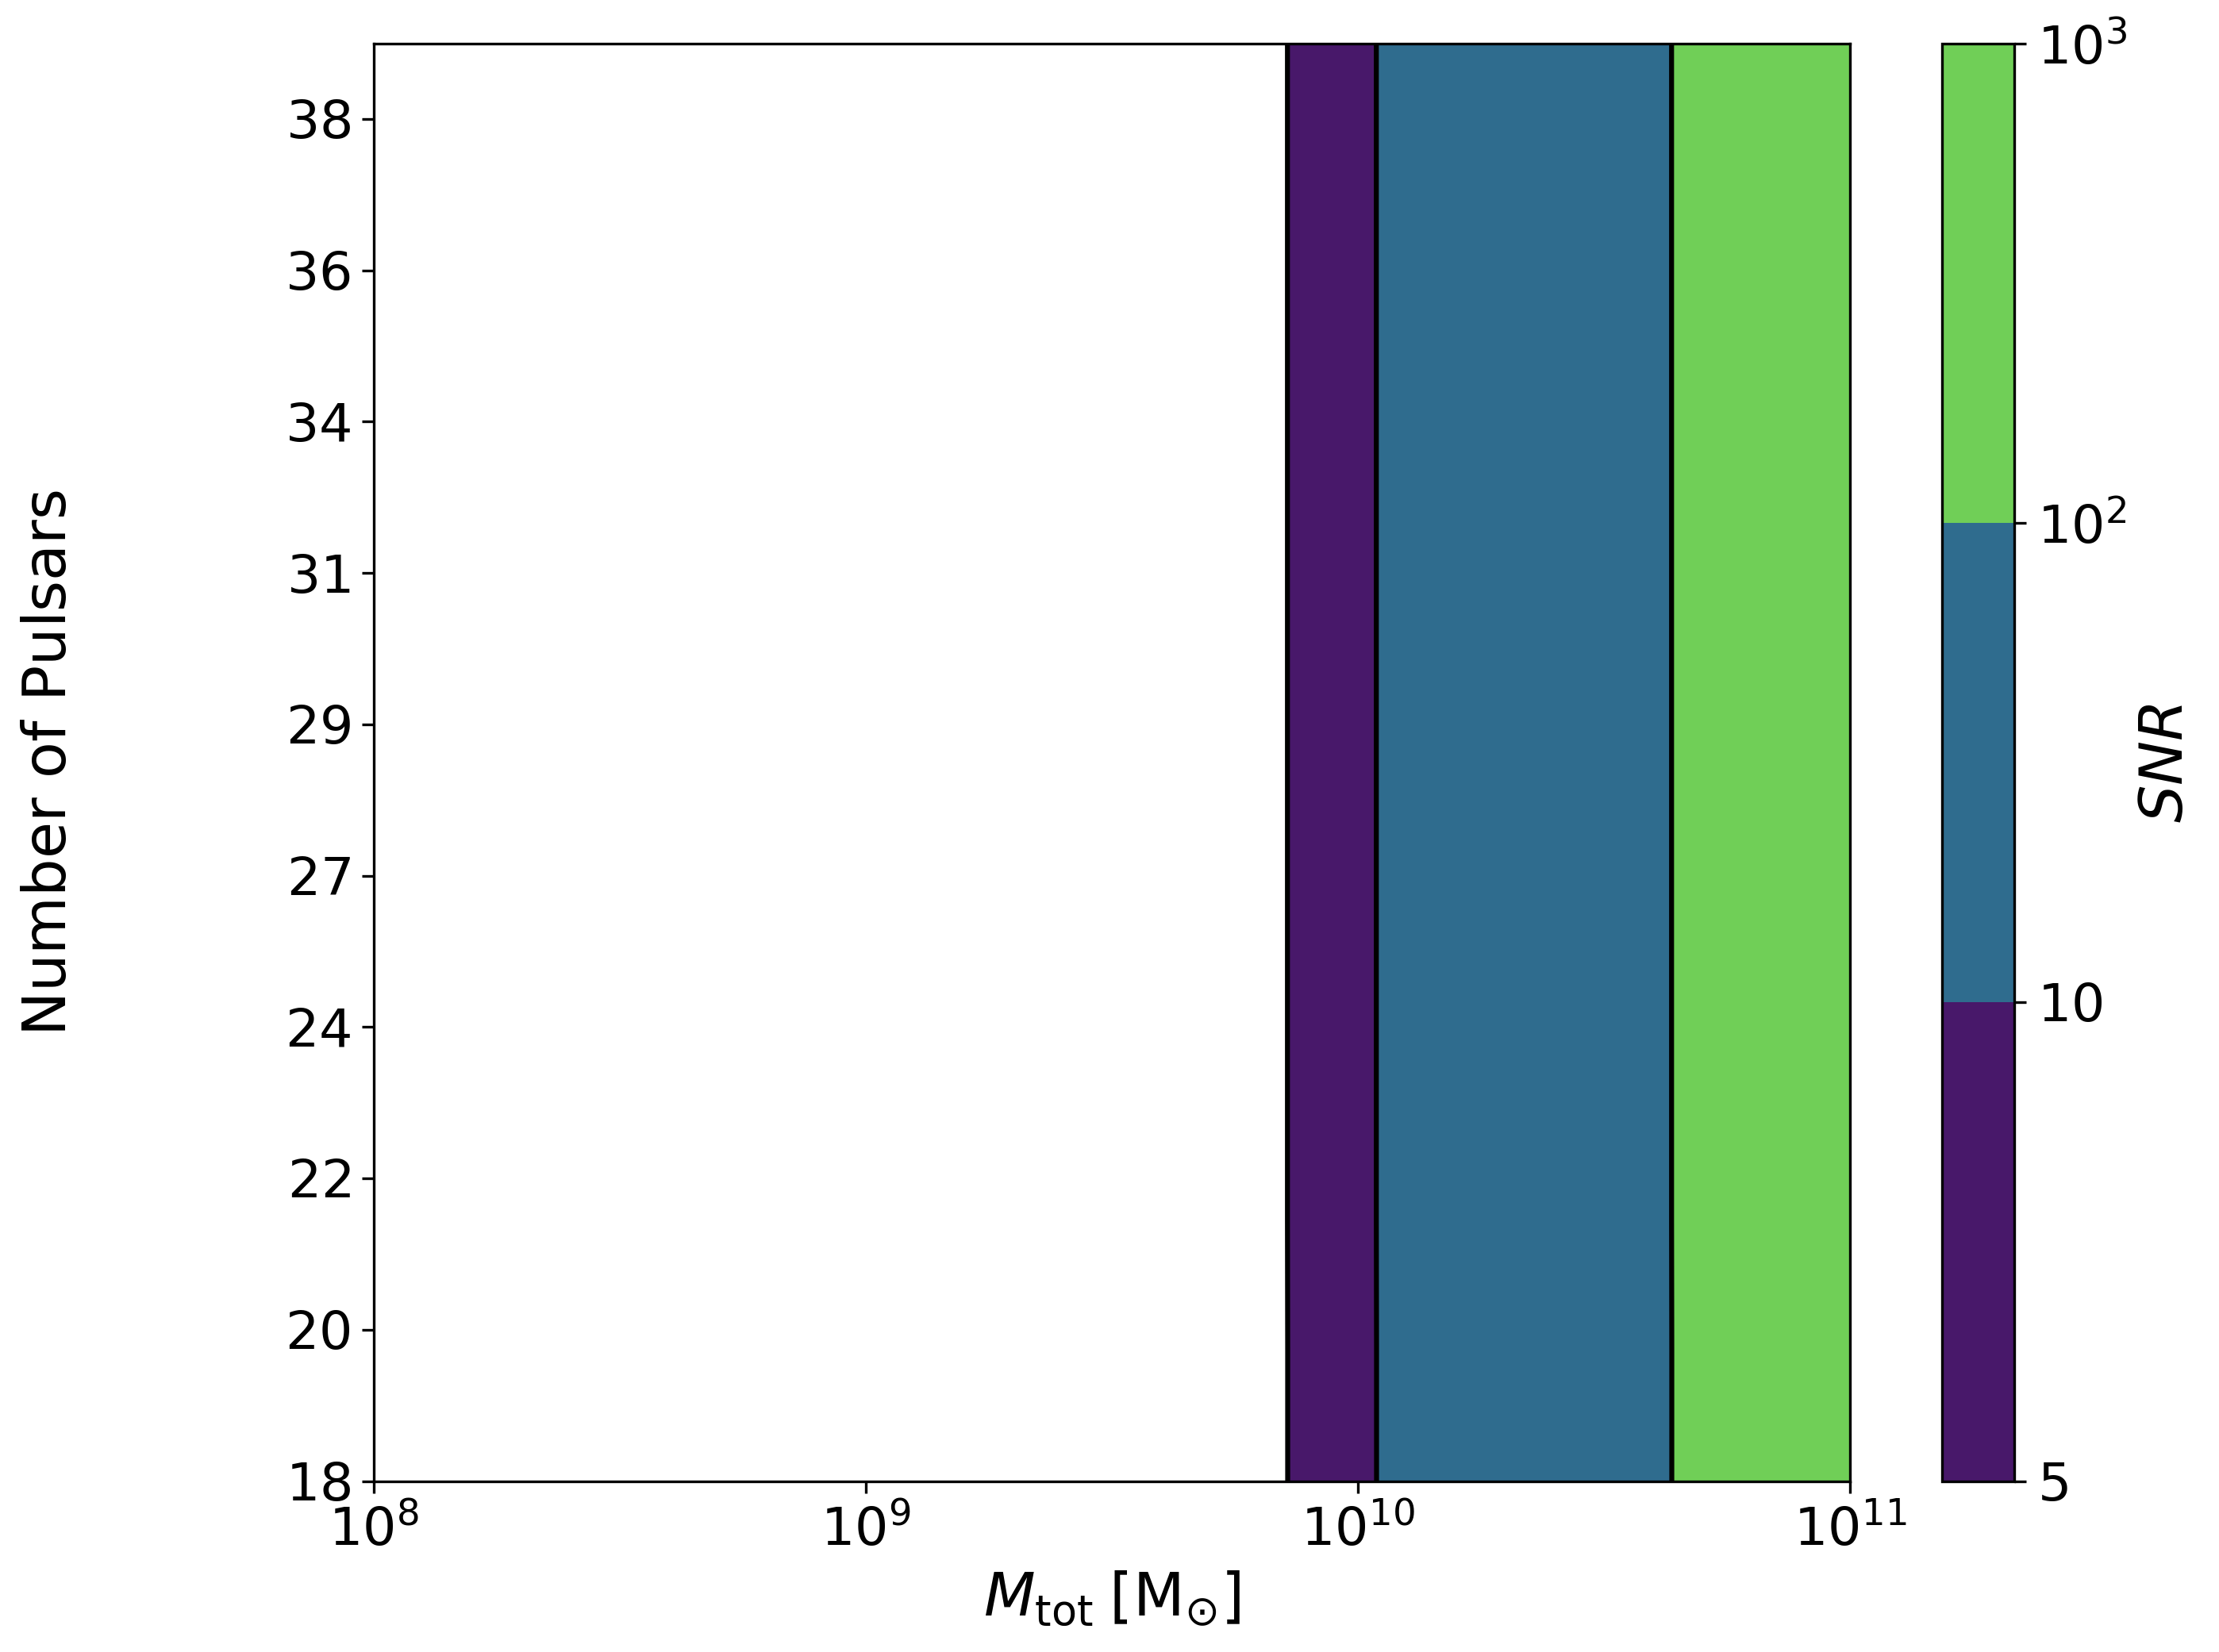

In [22]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False)

## Create of SNR Matrices and Samples for all models

### PTA Only Params

* 'n_p' - Number of Pulsars
* 'sigma' - Root-Mean-Squared Timing Error
* 'cadence' - Observation Cadence

### Global Detector Params

* 'T_obs' - Observation Time Length

In [44]:
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100
#Variable on y-axis
var_ys = ['n_p','sigma','cadence','T_obs']
#var_ys = ['z']
#Variable on x-axis
var_x = 'M'
#models = [2,4,5,7,9,10]
models = [4,5,6,7,9,10,11,12]
version = 'v4'

In [46]:
tmp = Get_Instrument(4)
print(tmp.var_dict)

{'n_p': {'val': 18, 'min': 18, 'max': 40, 'sampled': False}, 'T_obs': {'val': <Quantity 11.4 yr>, 'min': <Quantity 5. yr>, 'max': <Quantity 30. yr>, 'sampled': False}, 'sigma': {'val': <Quantity 1.e-07 s>, 'min': <Quantity 1.e-07 s>, 'max': <Quantity 5.e-07 s>, 'sampled': False}, 'cadence': {'val': <Quantity 26.08928571 1 / yr>, 'min': <Quantity 2. 1 / yr>, 'max': <Quantity 52.17857143 1 / yr>, 'sampled': False}}


In [49]:
for model in models:
    for var_y in var_ys:
        instrument = Get_Instrument(model)
        source = Get_Source(model)
        #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '_v3'+ '.png'
        save_snr_name = '{}_{}_vs_{}_SNR_{}.txt'.format(instrument.name,var_x,var_y,version)
        save_sample_name = '{}_{}_vs_{}_samples_{}.txt'.format(instrument.name,var_x,var_y,version)
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        
        end = time.time()
        if var_y == 'n_p':
            save_sample_name_x = '{}_{}_vs_{}_samples_{}_{}.txt'.format(instrument.name,var_x,var_y,var_x,version)
            save_sample_name_y = '{}_{}_vs_{}_samples_{}_{}.txt'.format(instrument.name,var_x,var_y,var_y,version)
            np.savetxt(save_snr_location+save_sample_name_x,sample_x)
            np.savetxt(save_snr_location+save_sample_name_y,sample_y.astype(int),fmt='%i')
            np.savetxt(save_snr_location+save_snr_name,SNRMatrix)
        else:
            snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)
        print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

T_obs :  18 
 [11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4
 11.4 11.4 11.4 11.4]
phi :  18 
 [5.16793814 3.52449474 0.05534312 1.92259246 4.6777037  1.88301459
 2.29068497 4.68699784 5.9035277  5.70398675 5.12700836 6.09310817
 5.91171264 5.33933365 5.28984064 5.19725779 5.33409427 6.06172006]
theta :  18 
 [1.10382848 1.06716114 1.38355941 2.23253493 1.53383942 1.48628414
 1.50575843 0.32752264 1.61854658 1.23122435 1.45571037 1.33568945
 1.43240682 1.82109346 1.52284736 0.42289713 1.26597872 1.25217807]
cadence :  18 
 [26.08928571 26.08928571 26.08928571 26.08928571 26.08928571 26.08928571
 26.08928571 26.08928571 26.08928571 26.08928571 26.08928571 26.08928571
 26.08928571 26.08928571 26.08928571 26.08928571 26.08928571 26.08928571]
sigma :  18 
 [1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]
T_obs :  18 
 [11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4 11.4

ValueError: T_obs must be a single value, or the same length as n_p: 20

### LISA Only Params

* 'L' - Detector Armlength
* 'A_acc' - Detector Acceleration Noise
* 'A_IFO' - Detector Optical Metrology Noise
* 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
* 'f_acc_break_high' - The High Acceleration Noise Break Frequency
* 'f_IFO_break' - The Optical Metrology Noise Break Frequency

### Global Detector Params

* 'T_obs' - Observation Time Length

In [40]:
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100
#Variable on y-axis
var_ys = ['L','A_acc','A_IFO','f_acc_break_low','f_acc_break_high','f_IFO_break','T_obs']
#Variable on x-axis
var_x = 'M'
model = 12

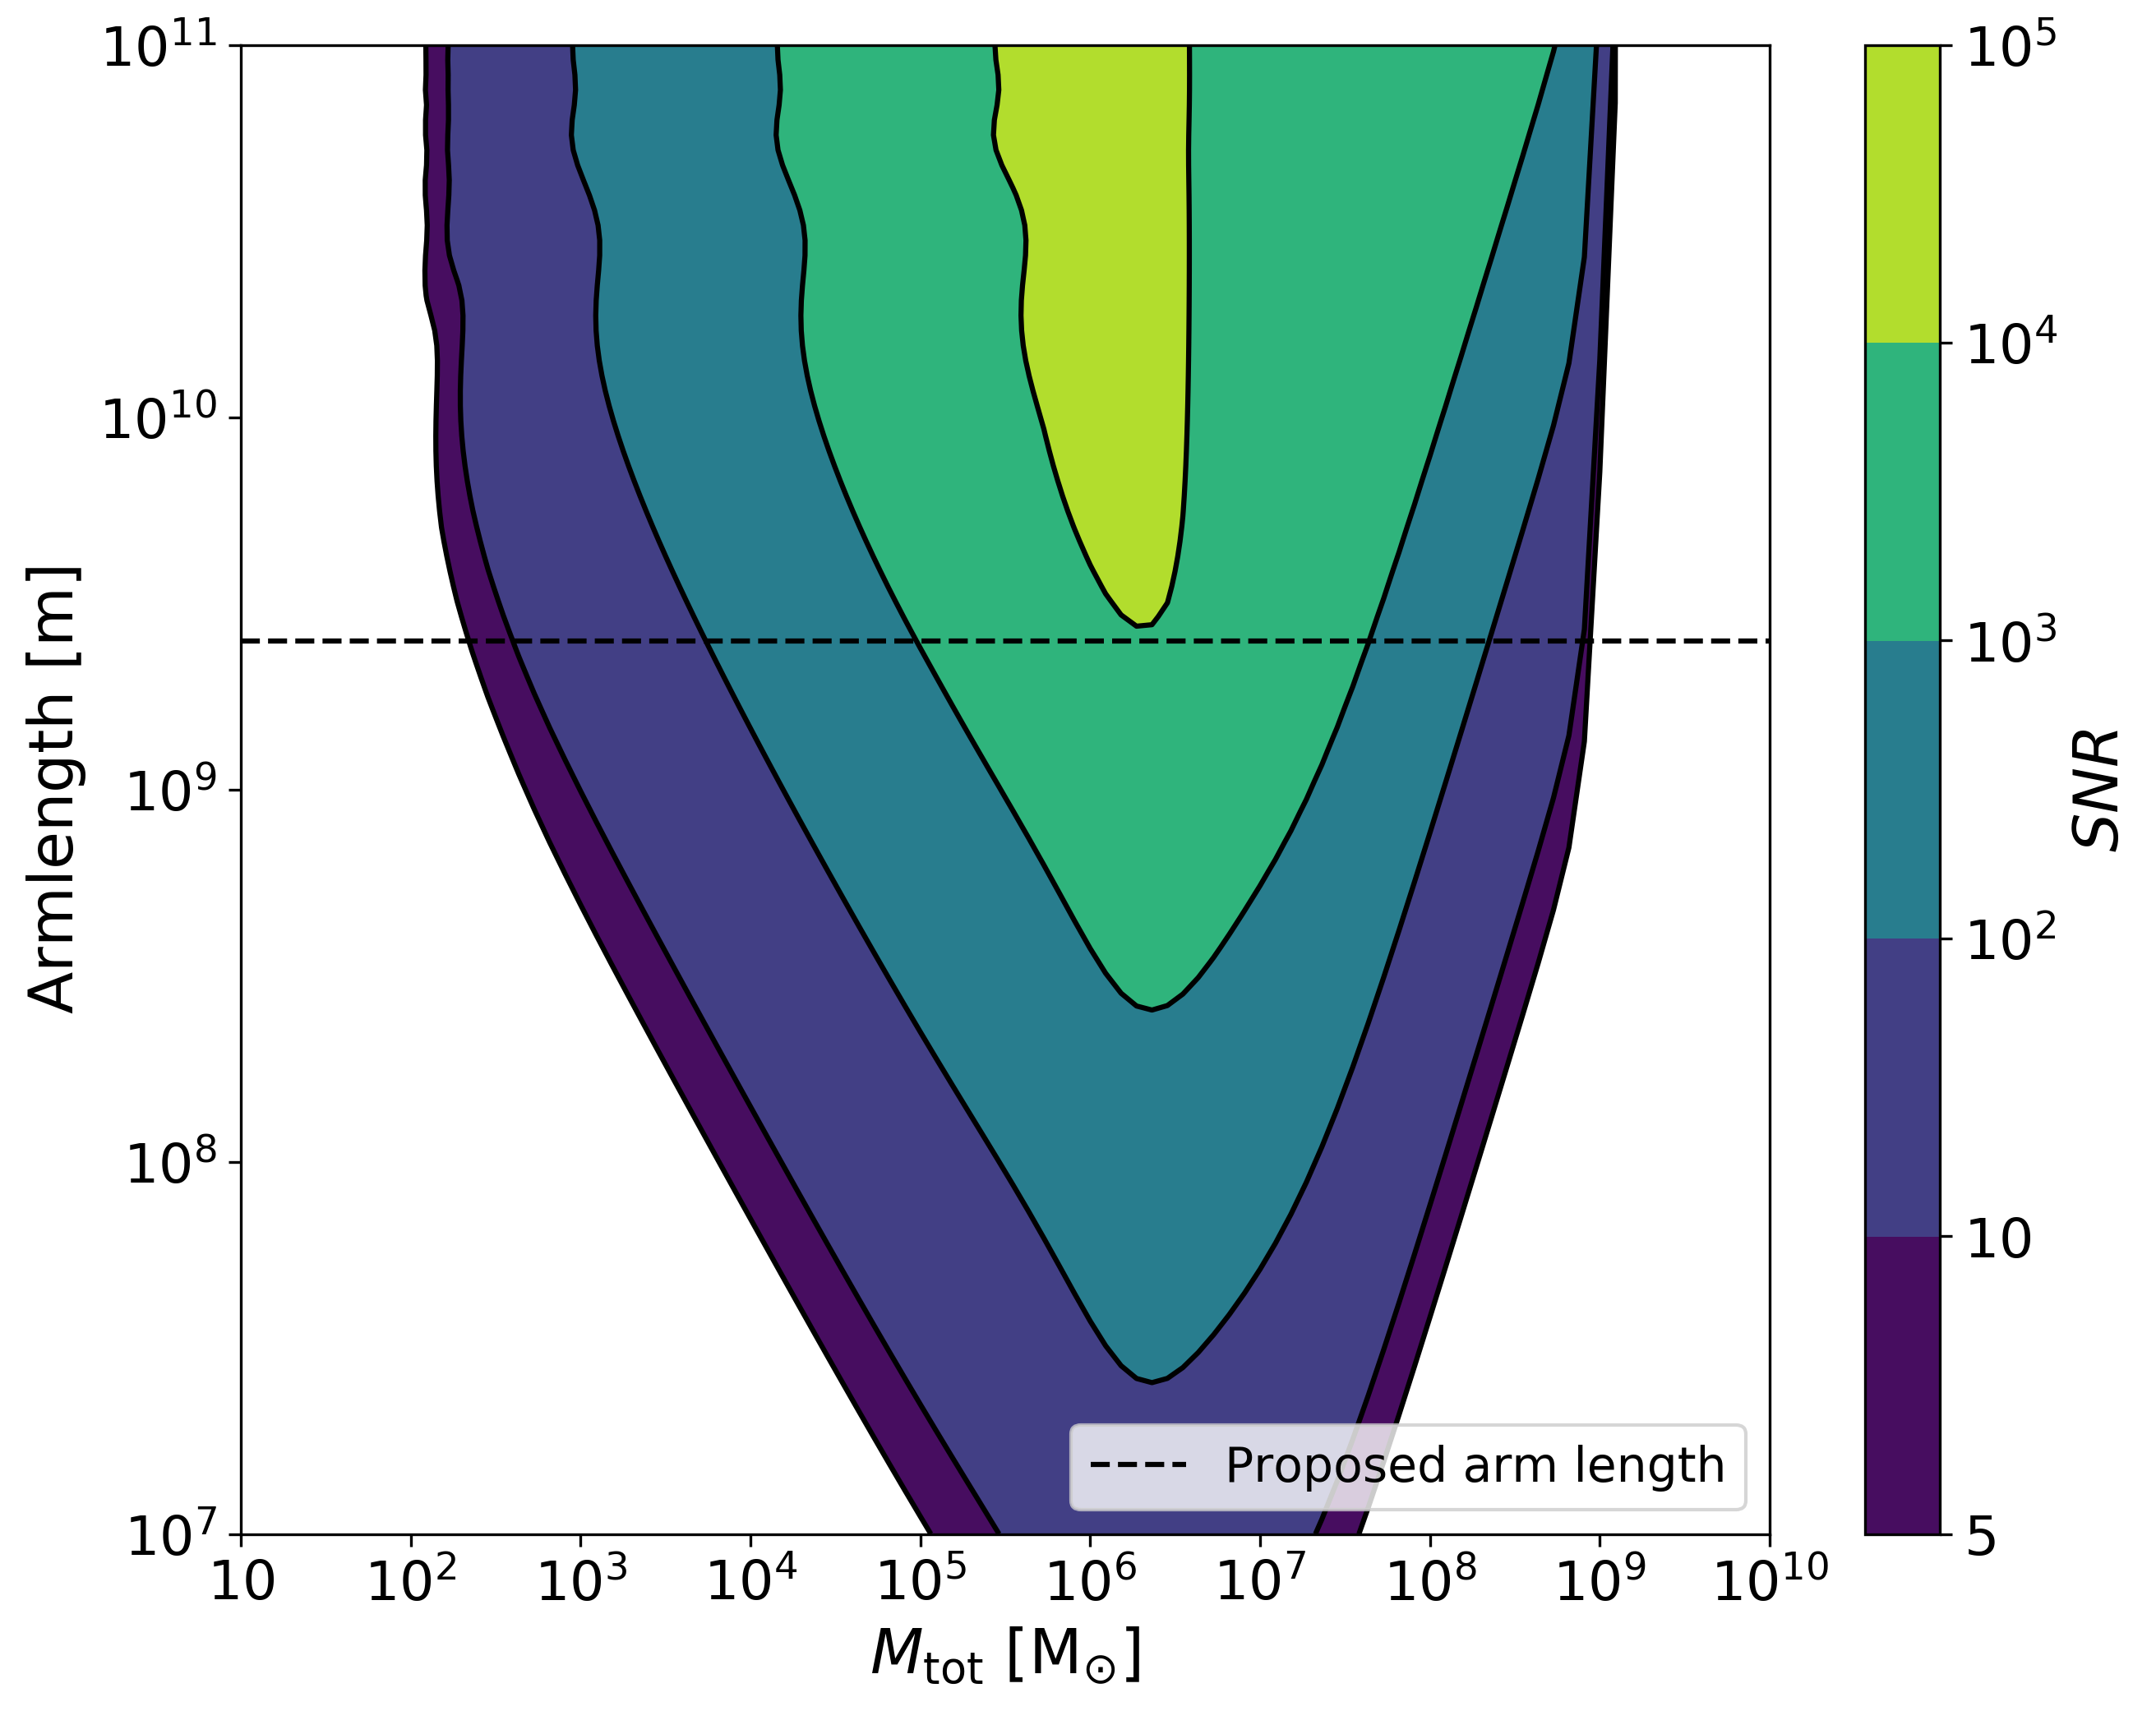

Model:  LISA_ESA_w_background_M_vs_L ,  done. t = :  133.05852890014648


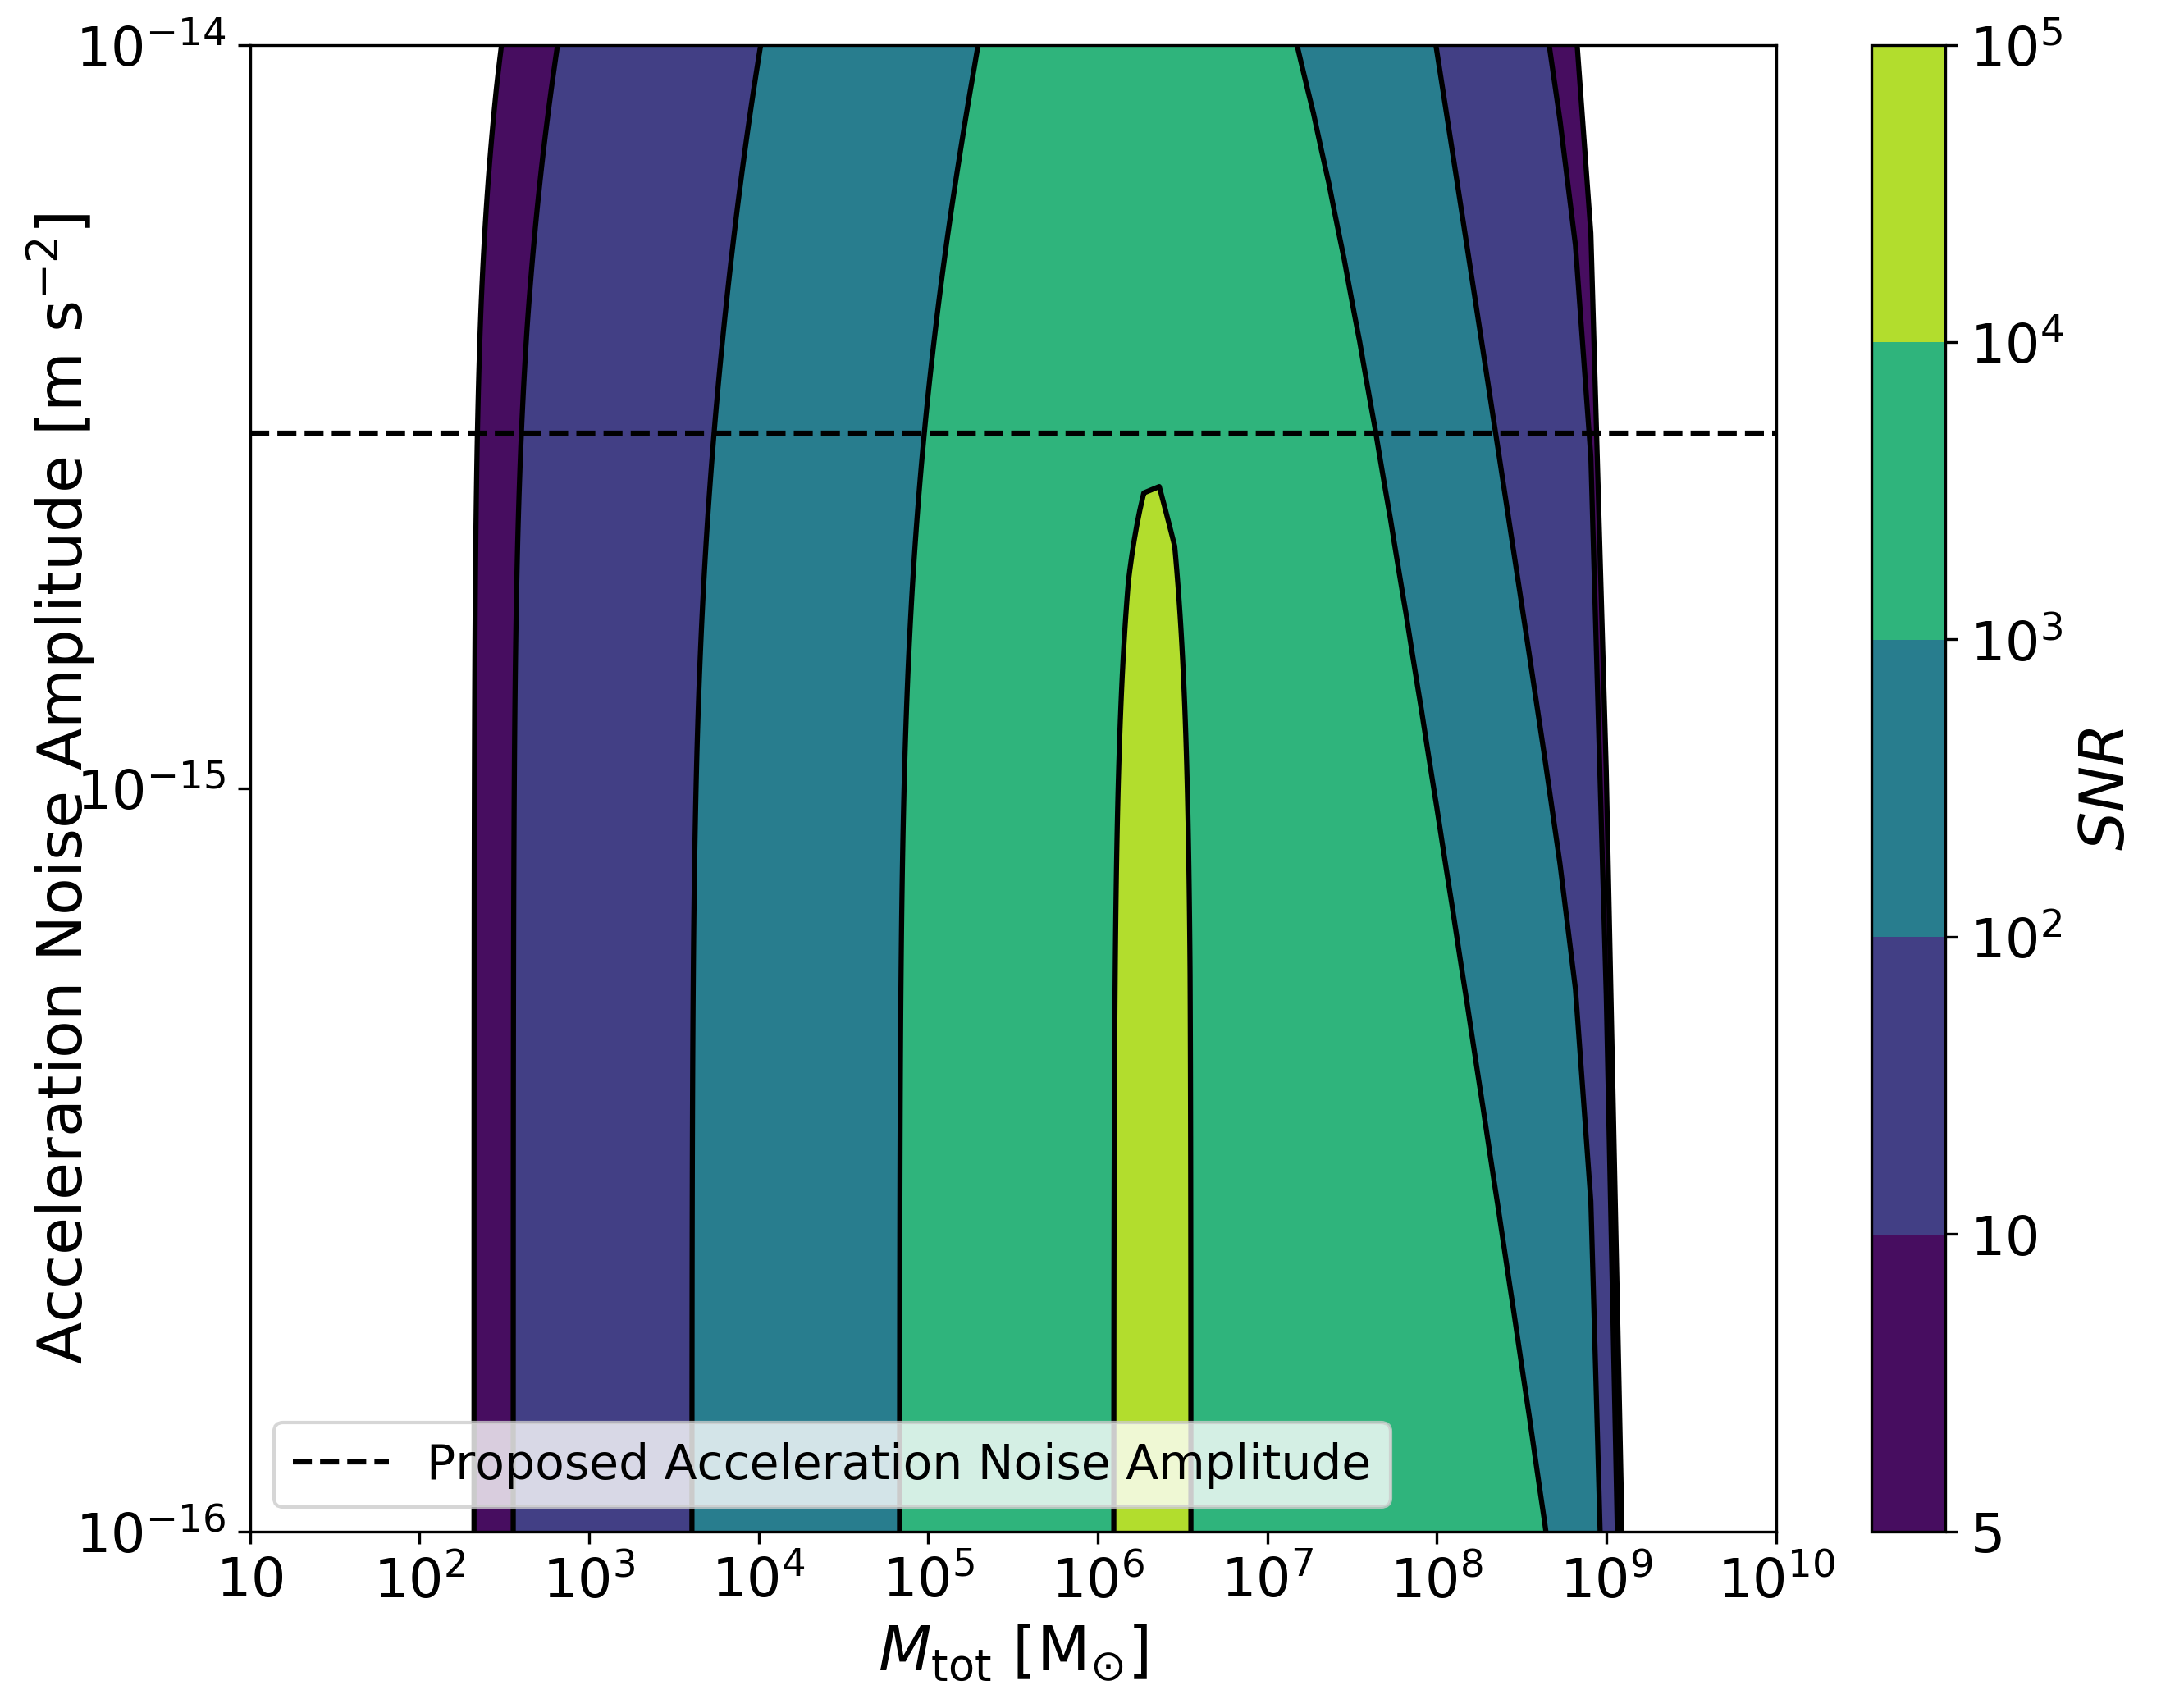

Model:  LISA_ESA_w_background_M_vs_A_acc ,  done. t = :  132.04591846466064


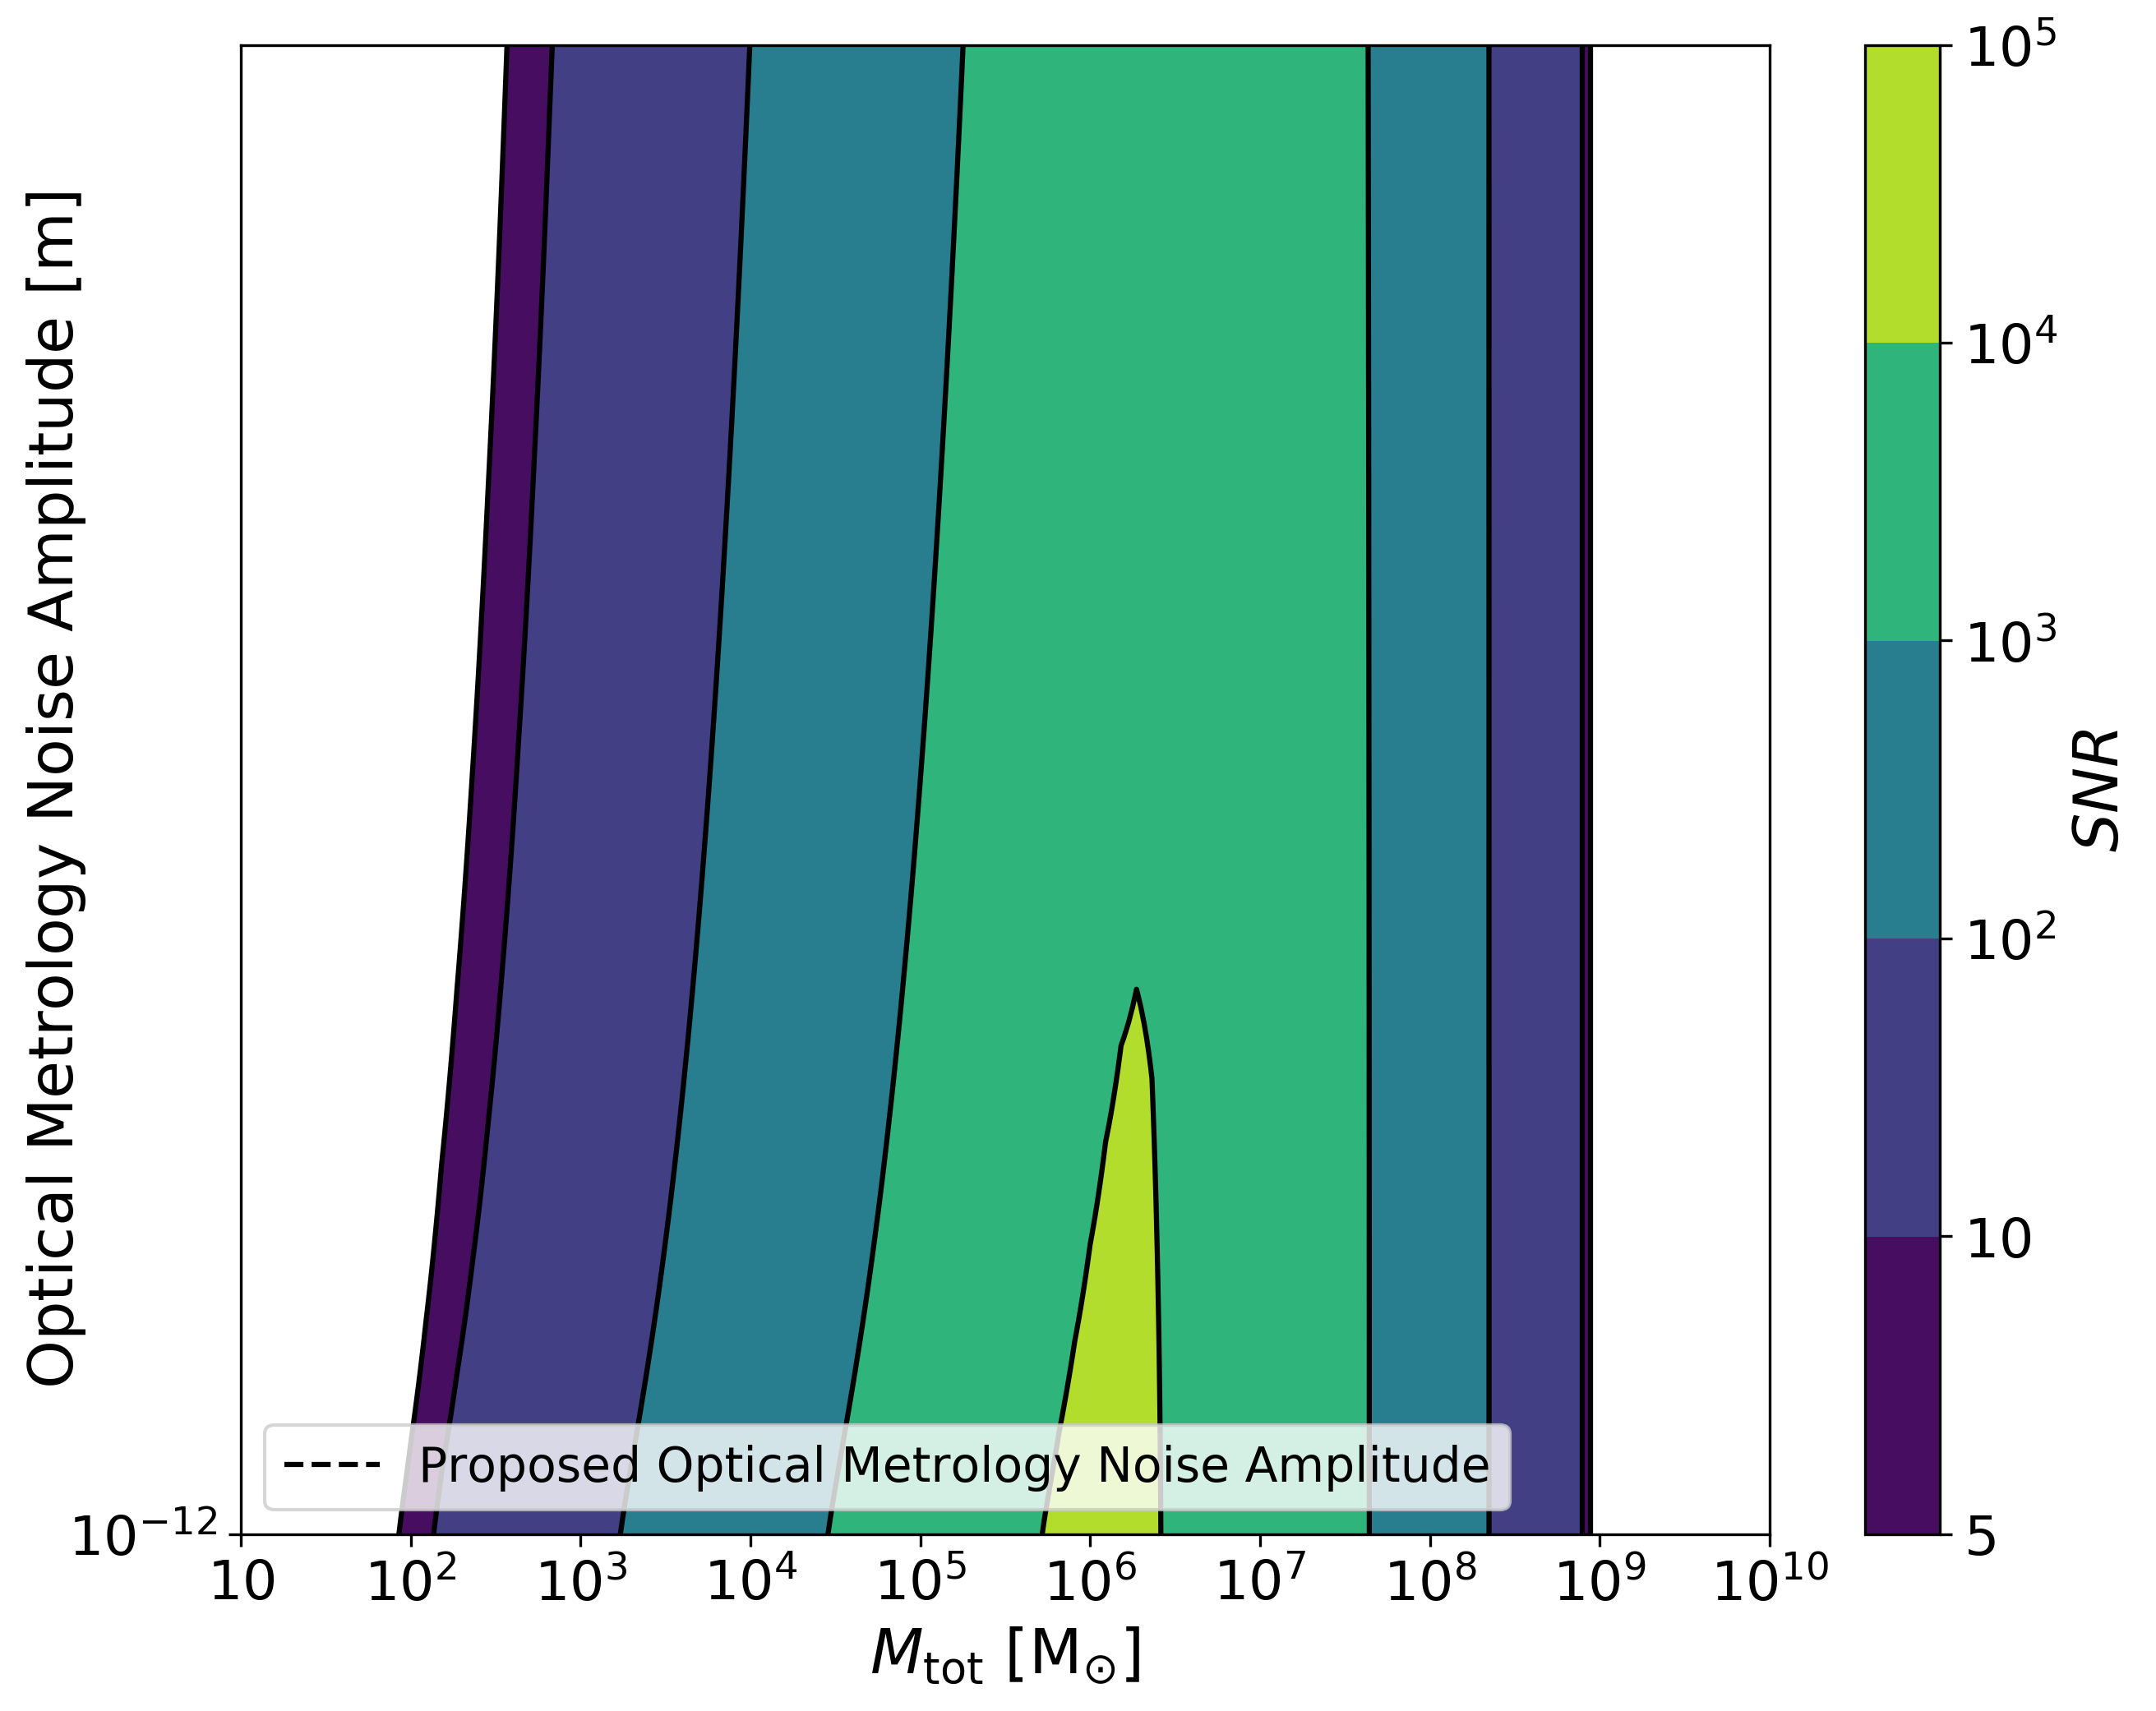

Model:  LISA_ESA_w_background_M_vs_A_IFO ,  done. t = :  134.40818691253662


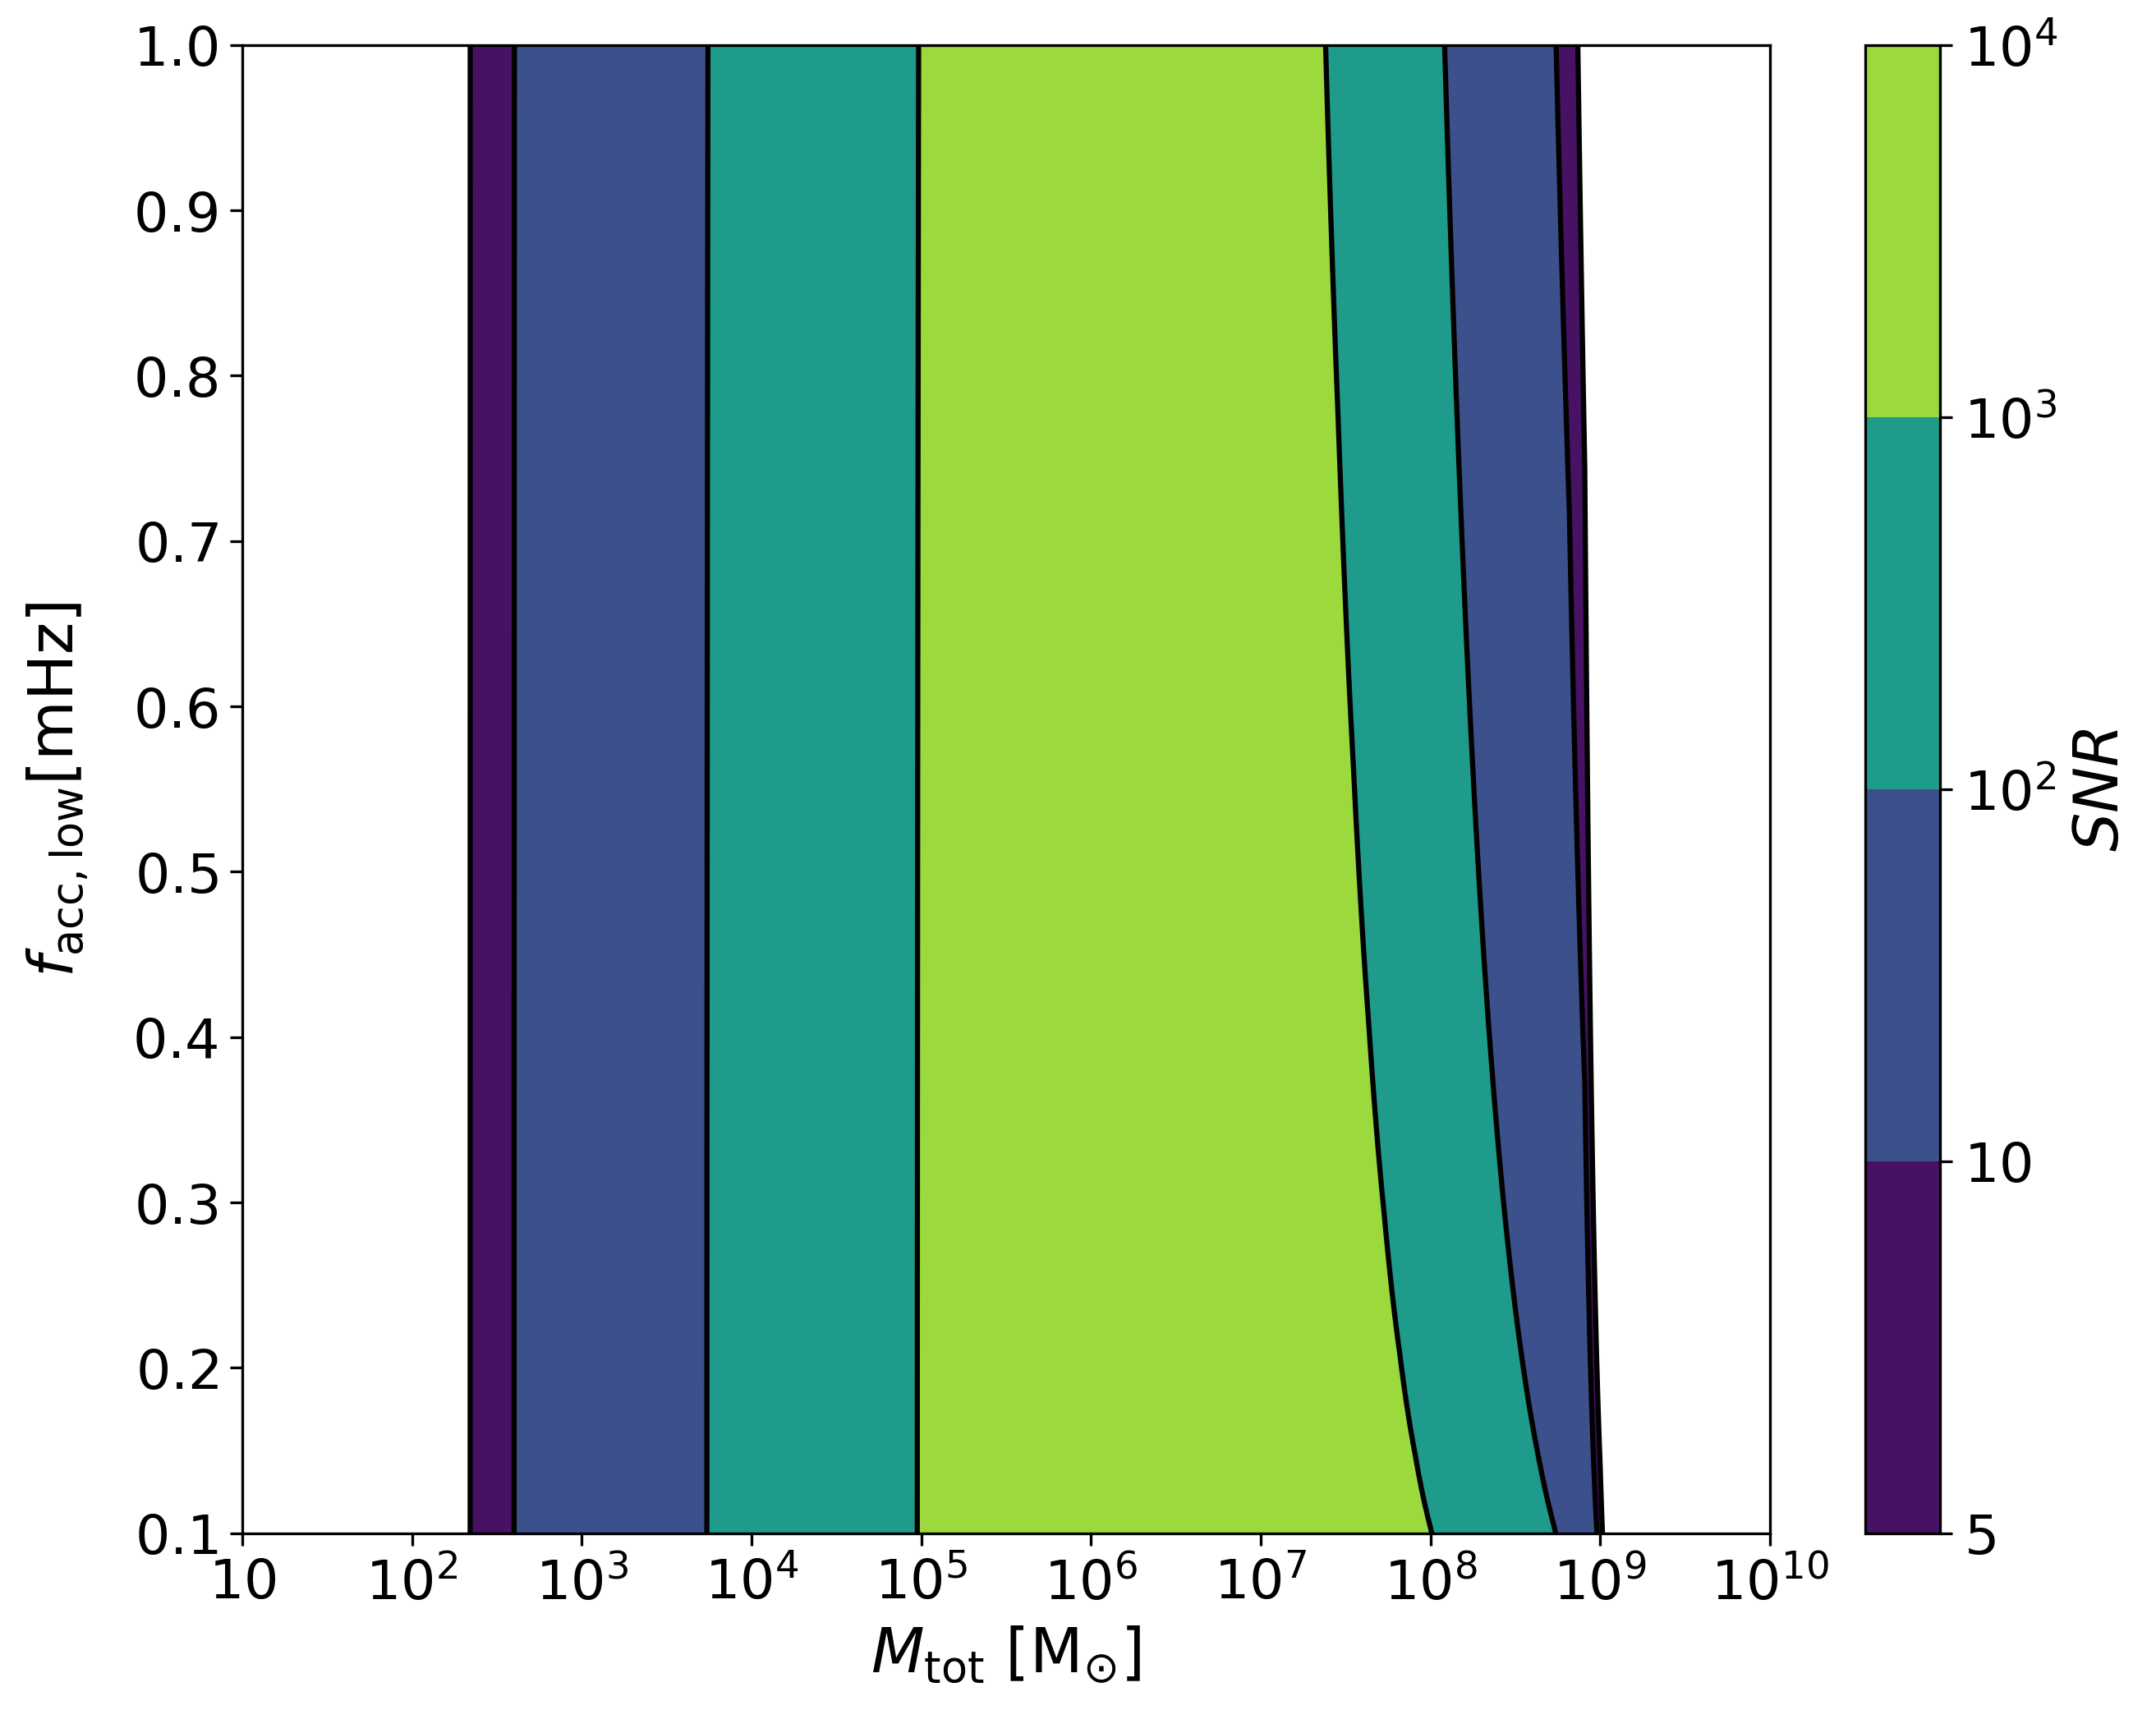

Model:  LISA_ESA_w_background_M_vs_f_acc_break_low ,  done. t = :  139.91593146324158


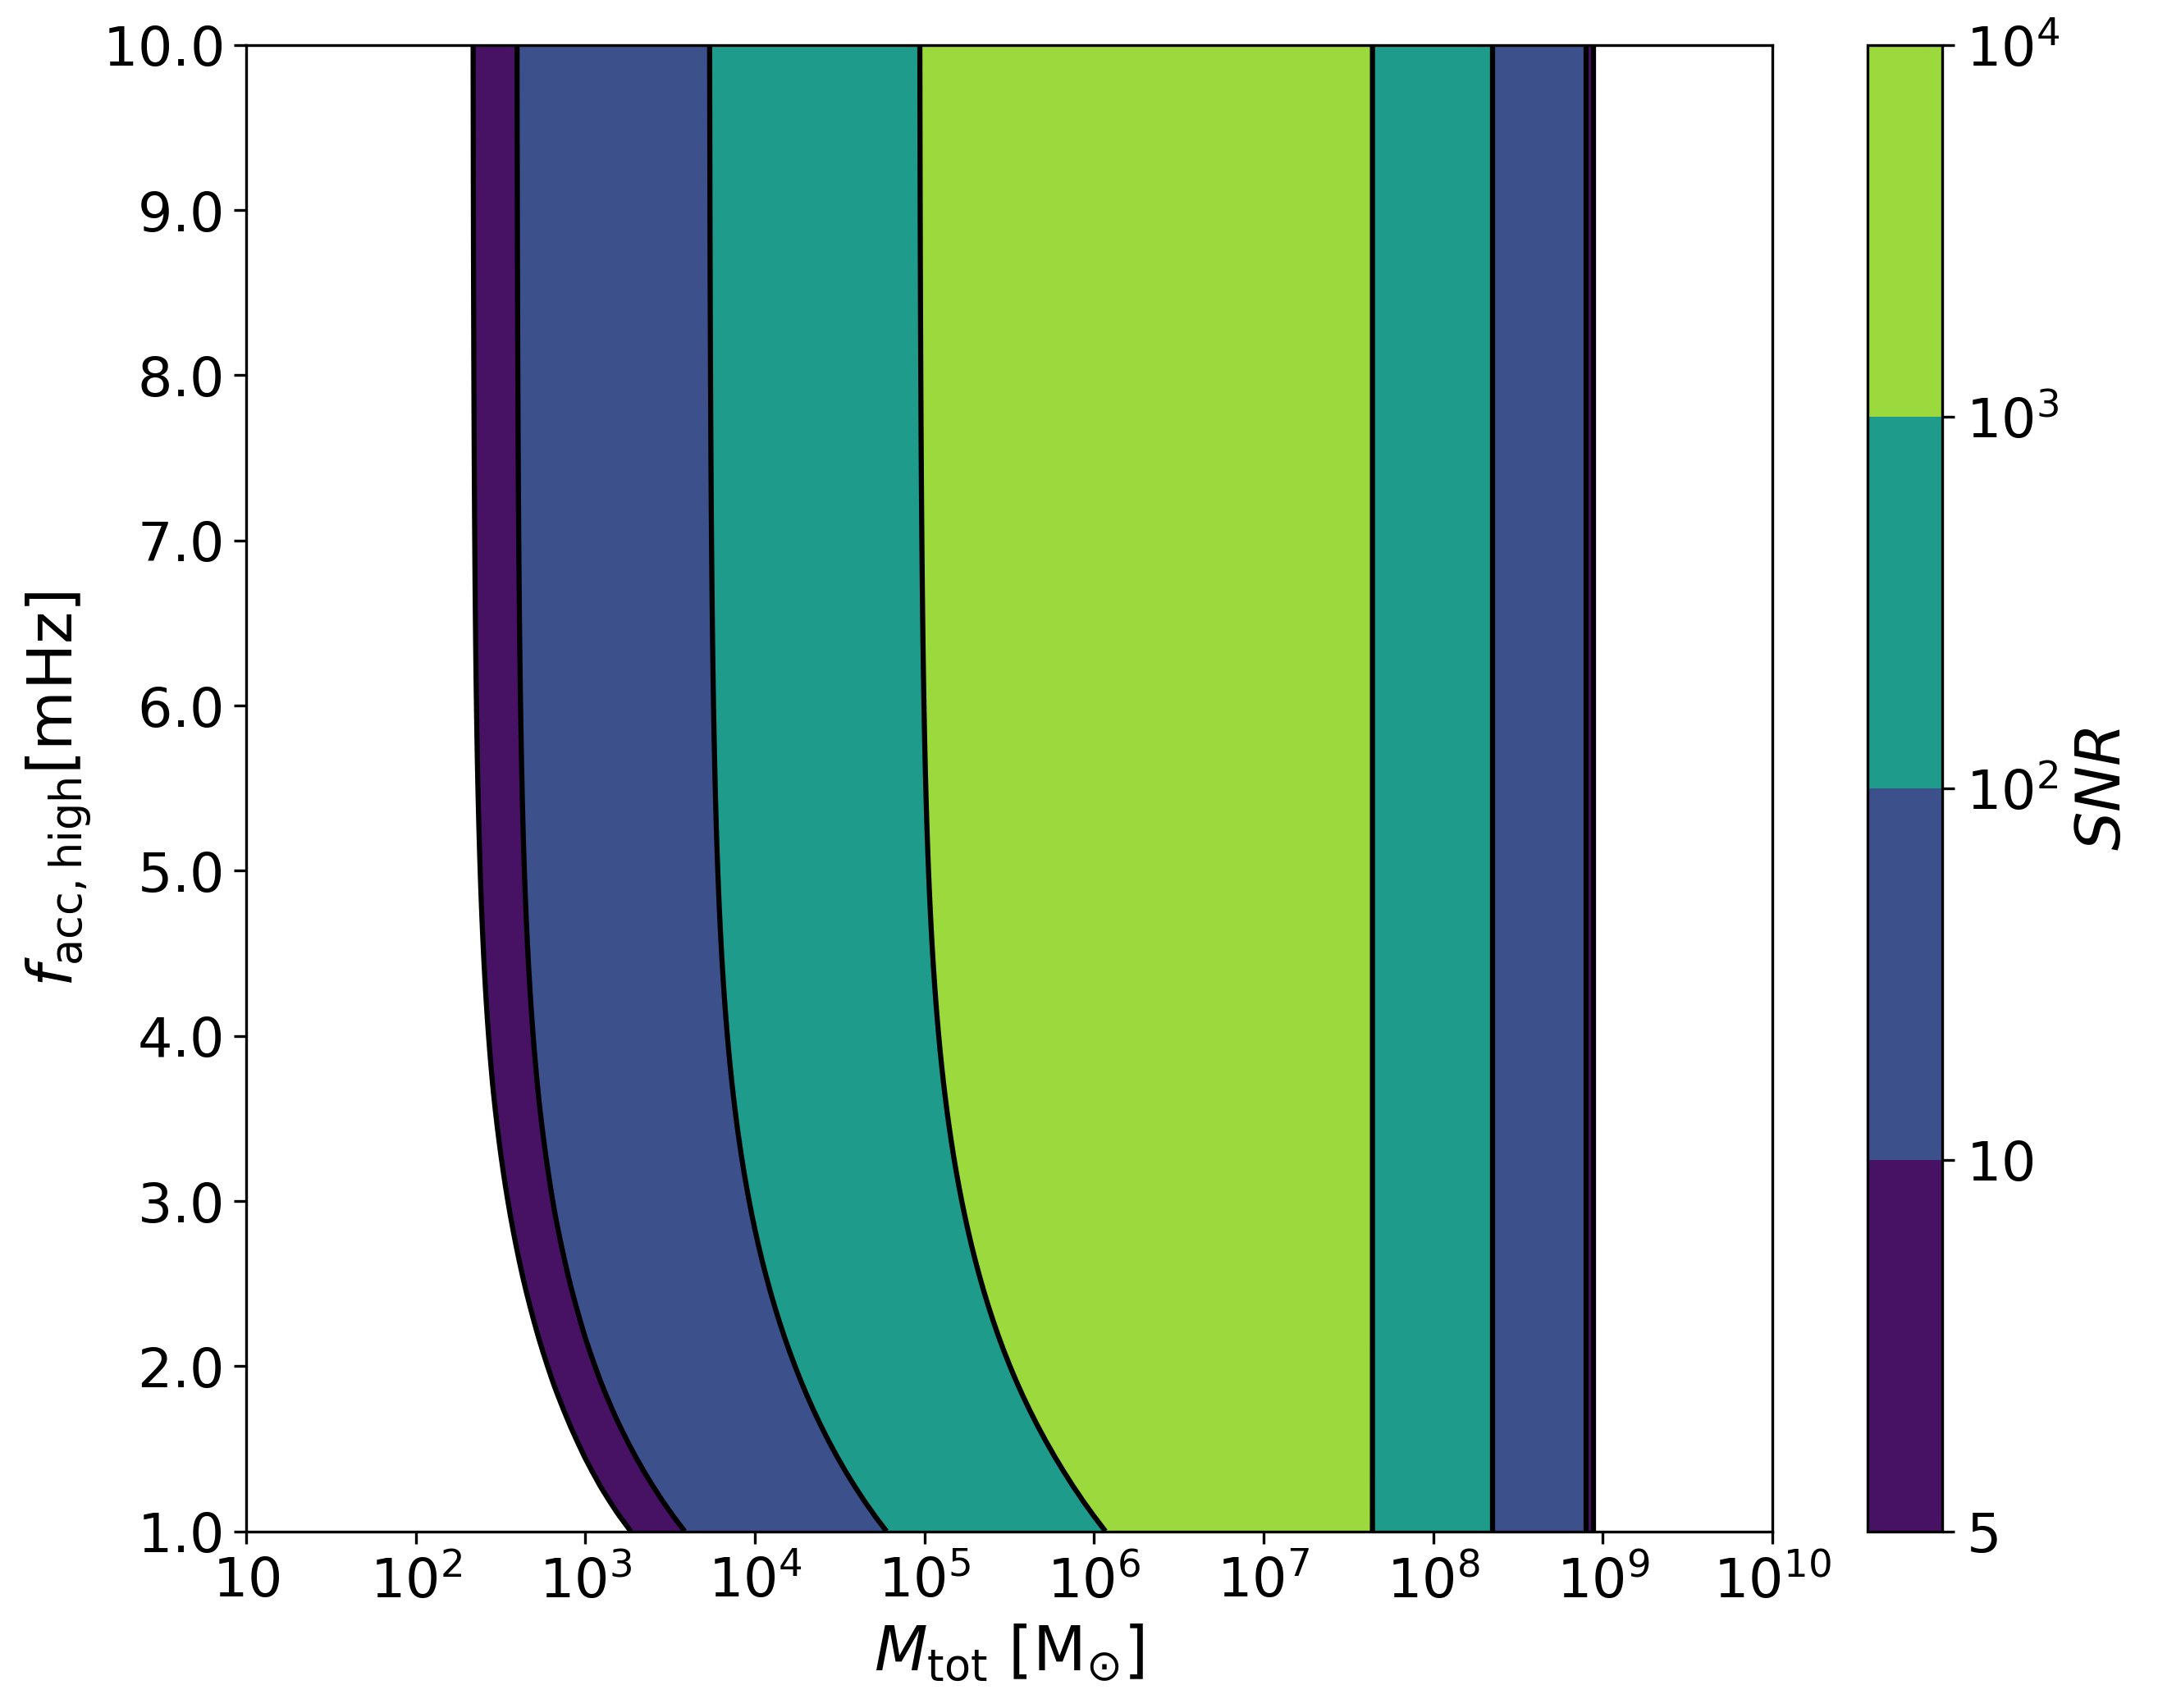

Model:  LISA_ESA_w_background_M_vs_f_acc_break_high ,  done. t = :  132.56219291687012


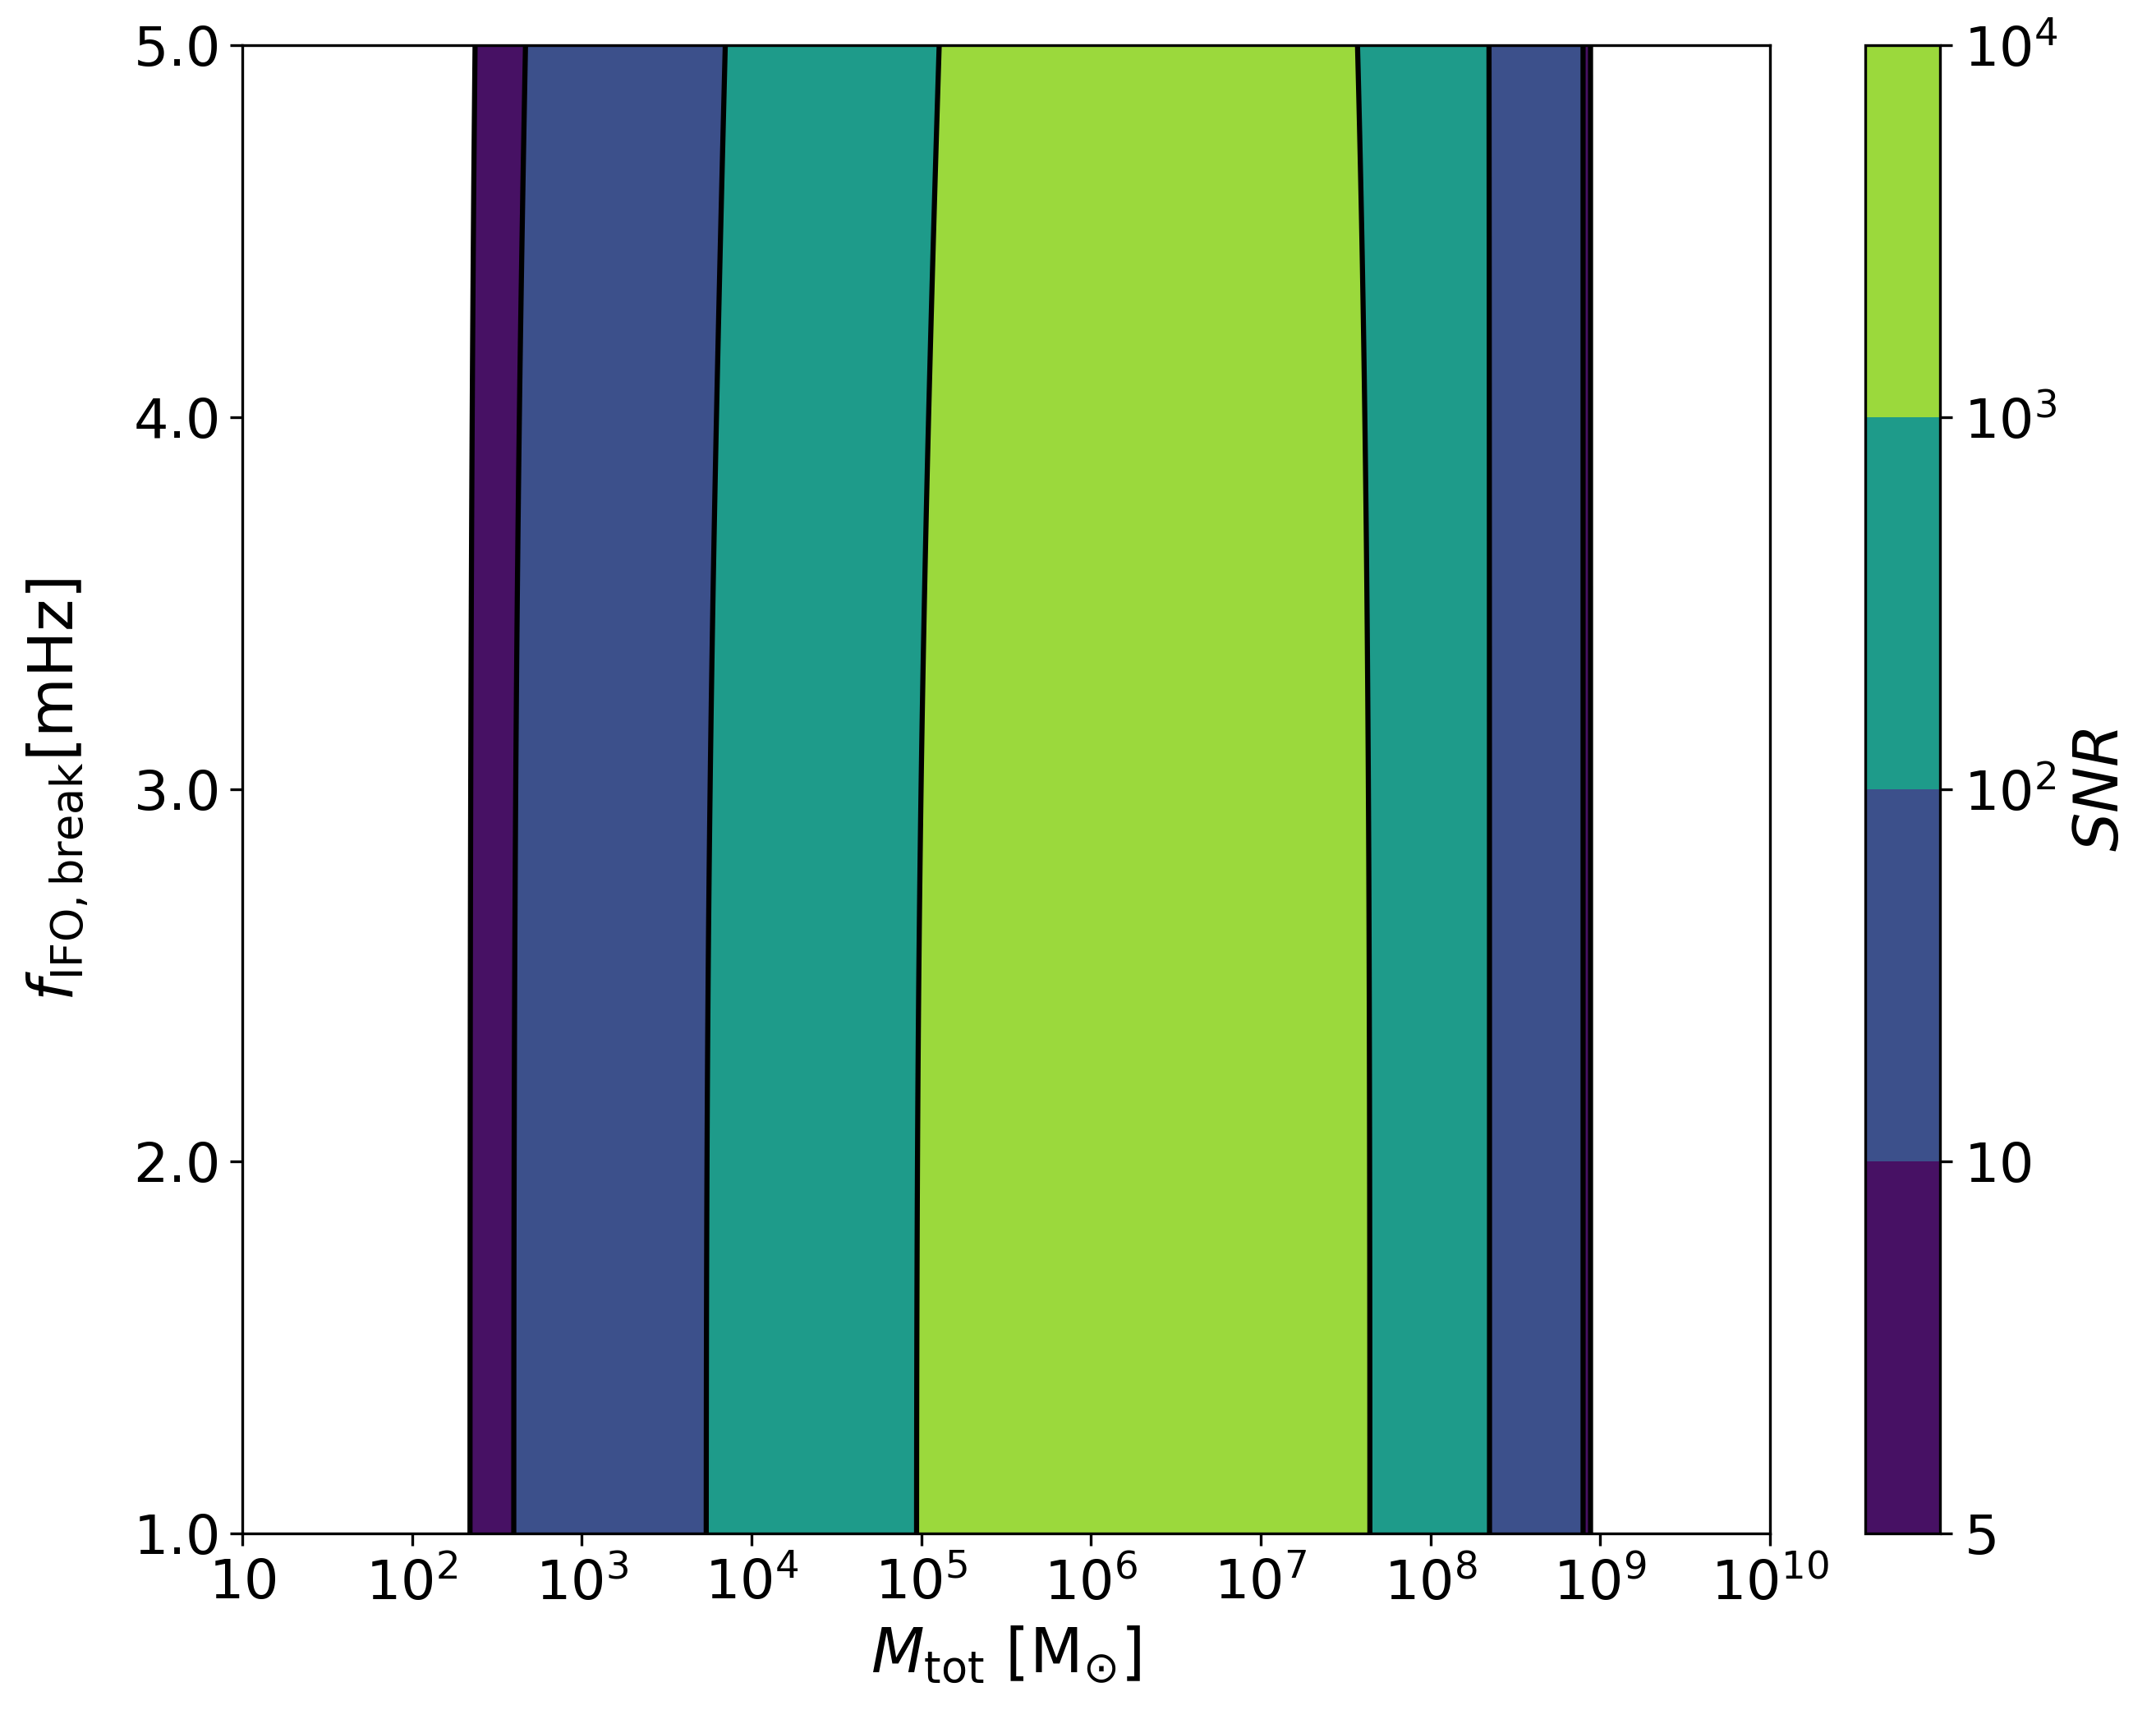

Model:  LISA_ESA_w_background_M_vs_f_IFO_break ,  done. t = :  134.93497681617737


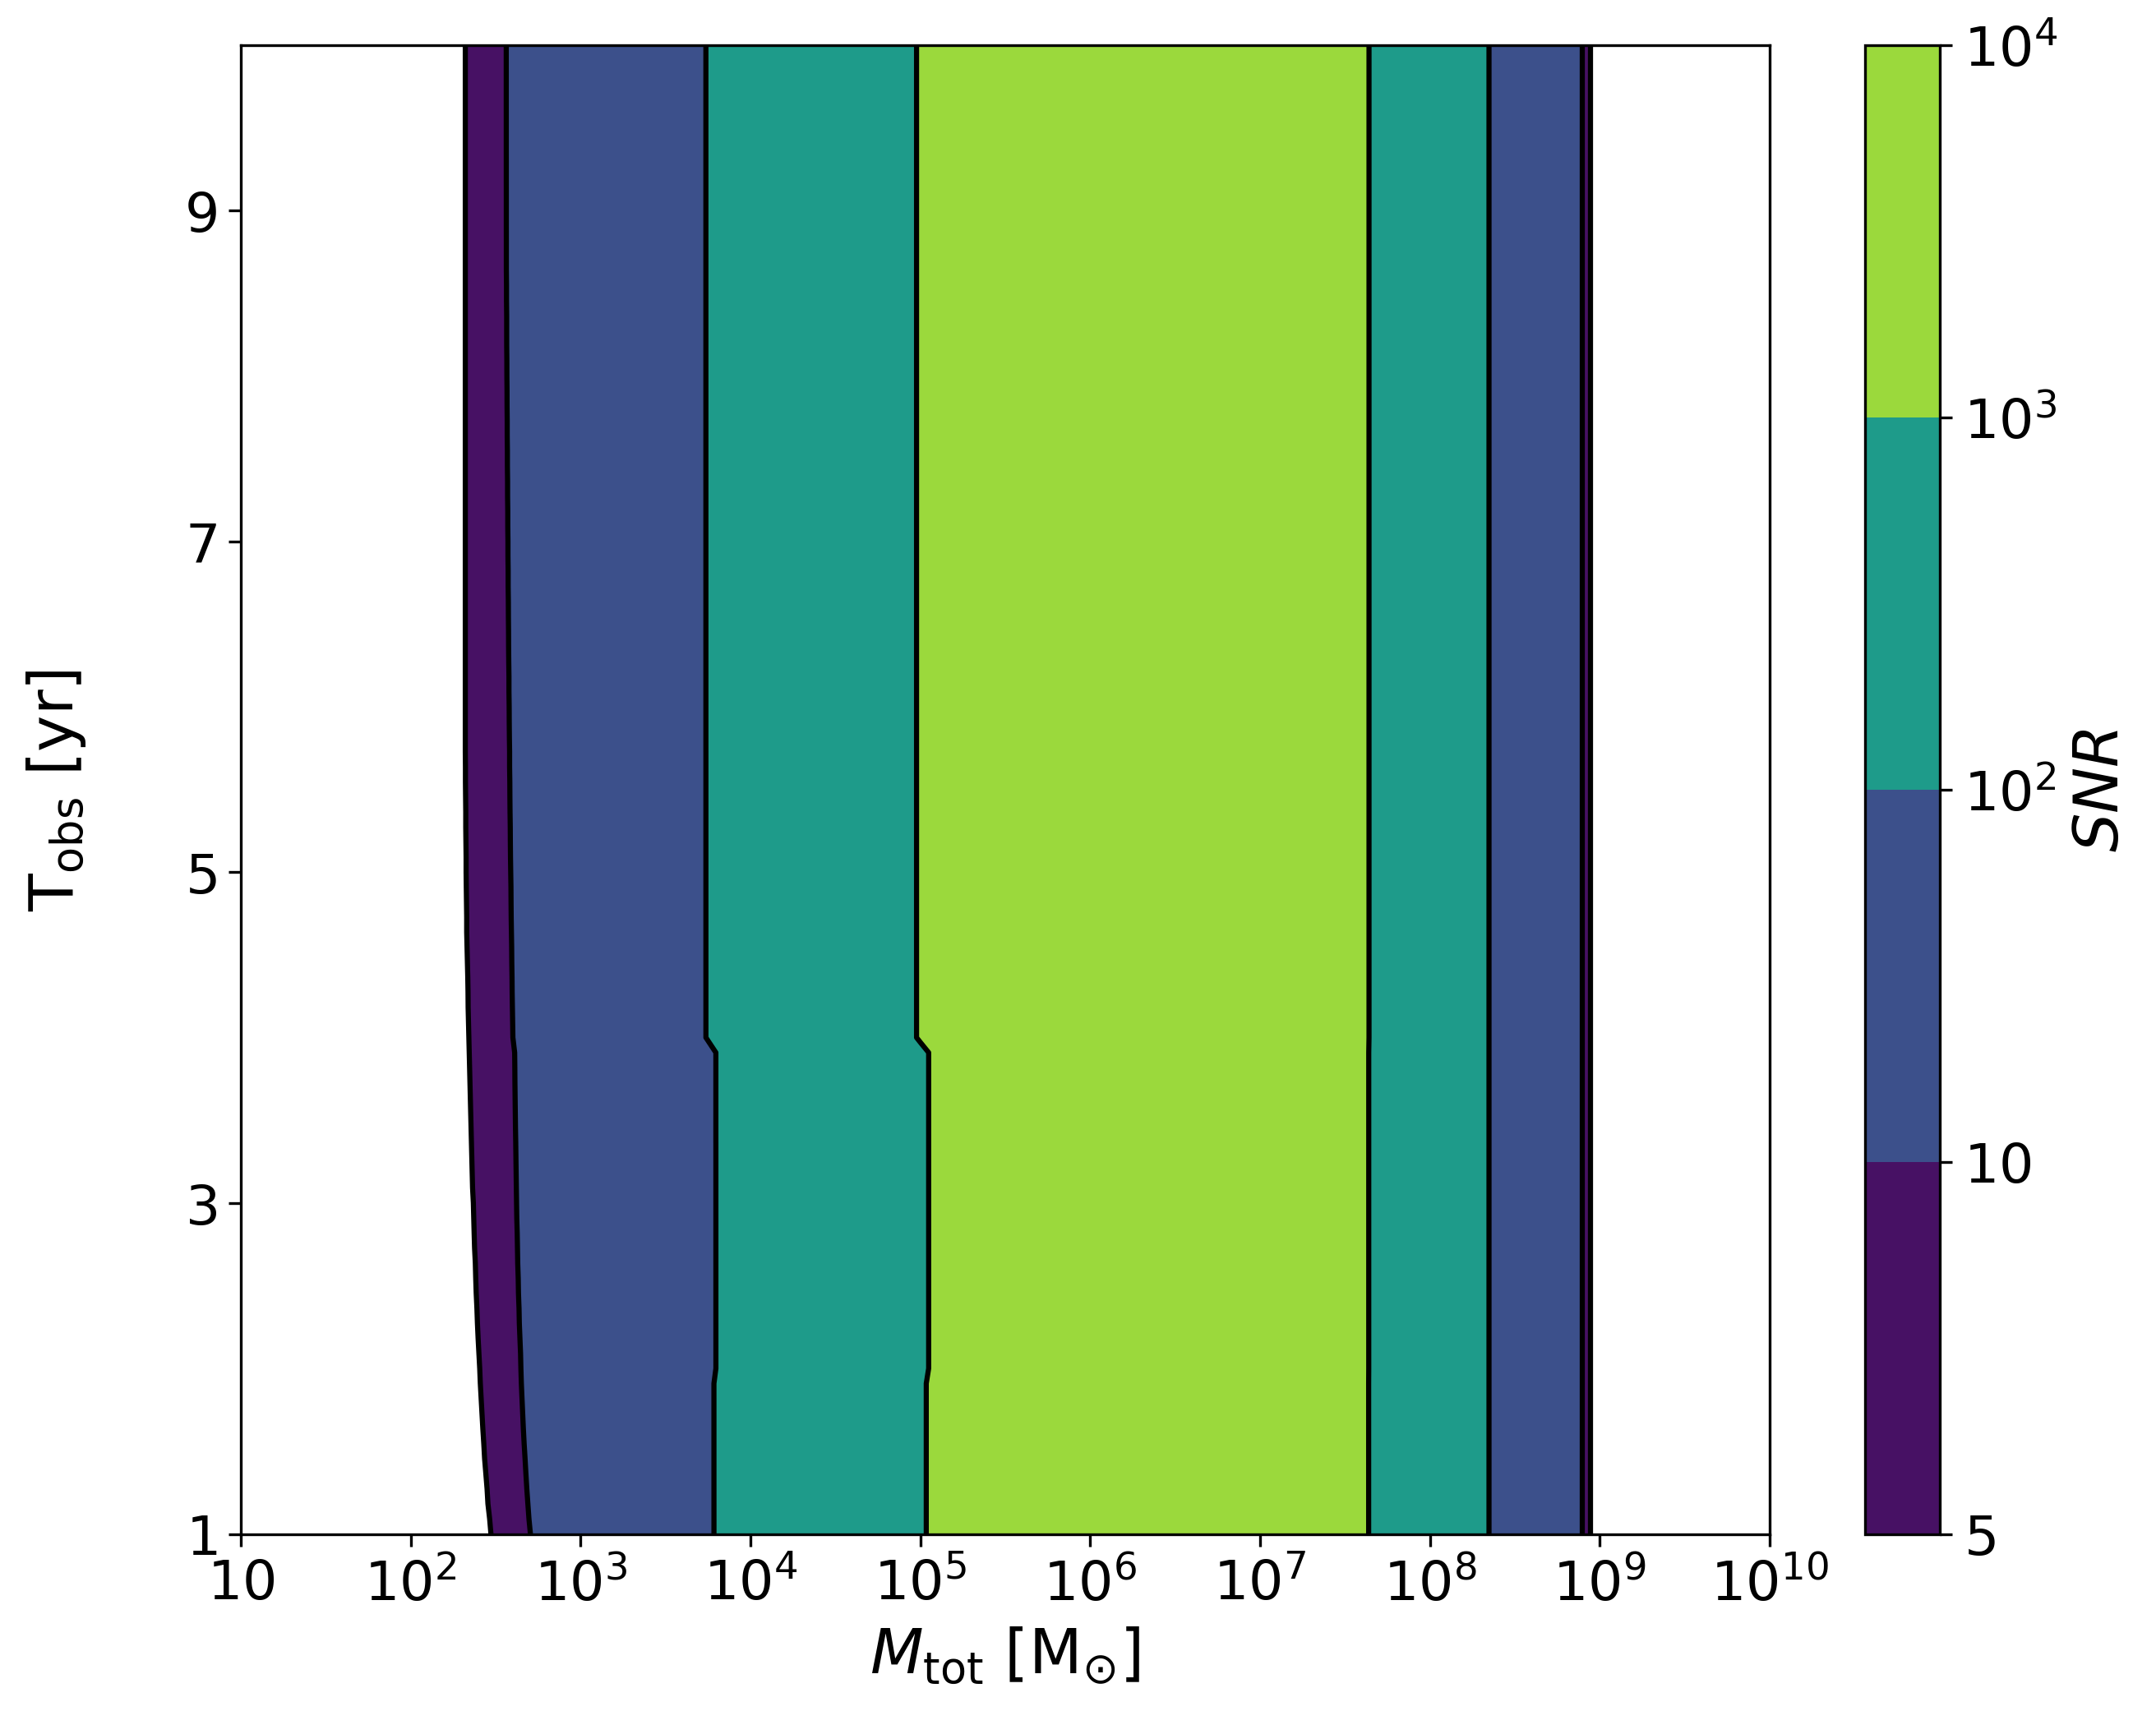

Model:  LISA_ESA_w_background_M_vs_T_obs ,  done. t = :  133.973552942276


In [45]:
for var_y in var_ys:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '.png'
    save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_SNR_v2.txt'
    save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_v2.txt'
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                     dl_axis=False,smooth_contours=False)
    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

### Global Source Params for all Fiducial Detectors

* 'M' - Mass (Solar Units)
* 'q' - Mass Ratio
* 'chi1' - Dimensionless Spin of Black Hole 1
* 'chi2' - Dimensionless Spin of Black Hole 2
* 'z' - Redshift

In [30]:
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100
#Variable on y-axis
var_ys = ['q','chi1','z']
#Variable on x-axis
var_x = 'L'
#models = range(13)
models = [12]

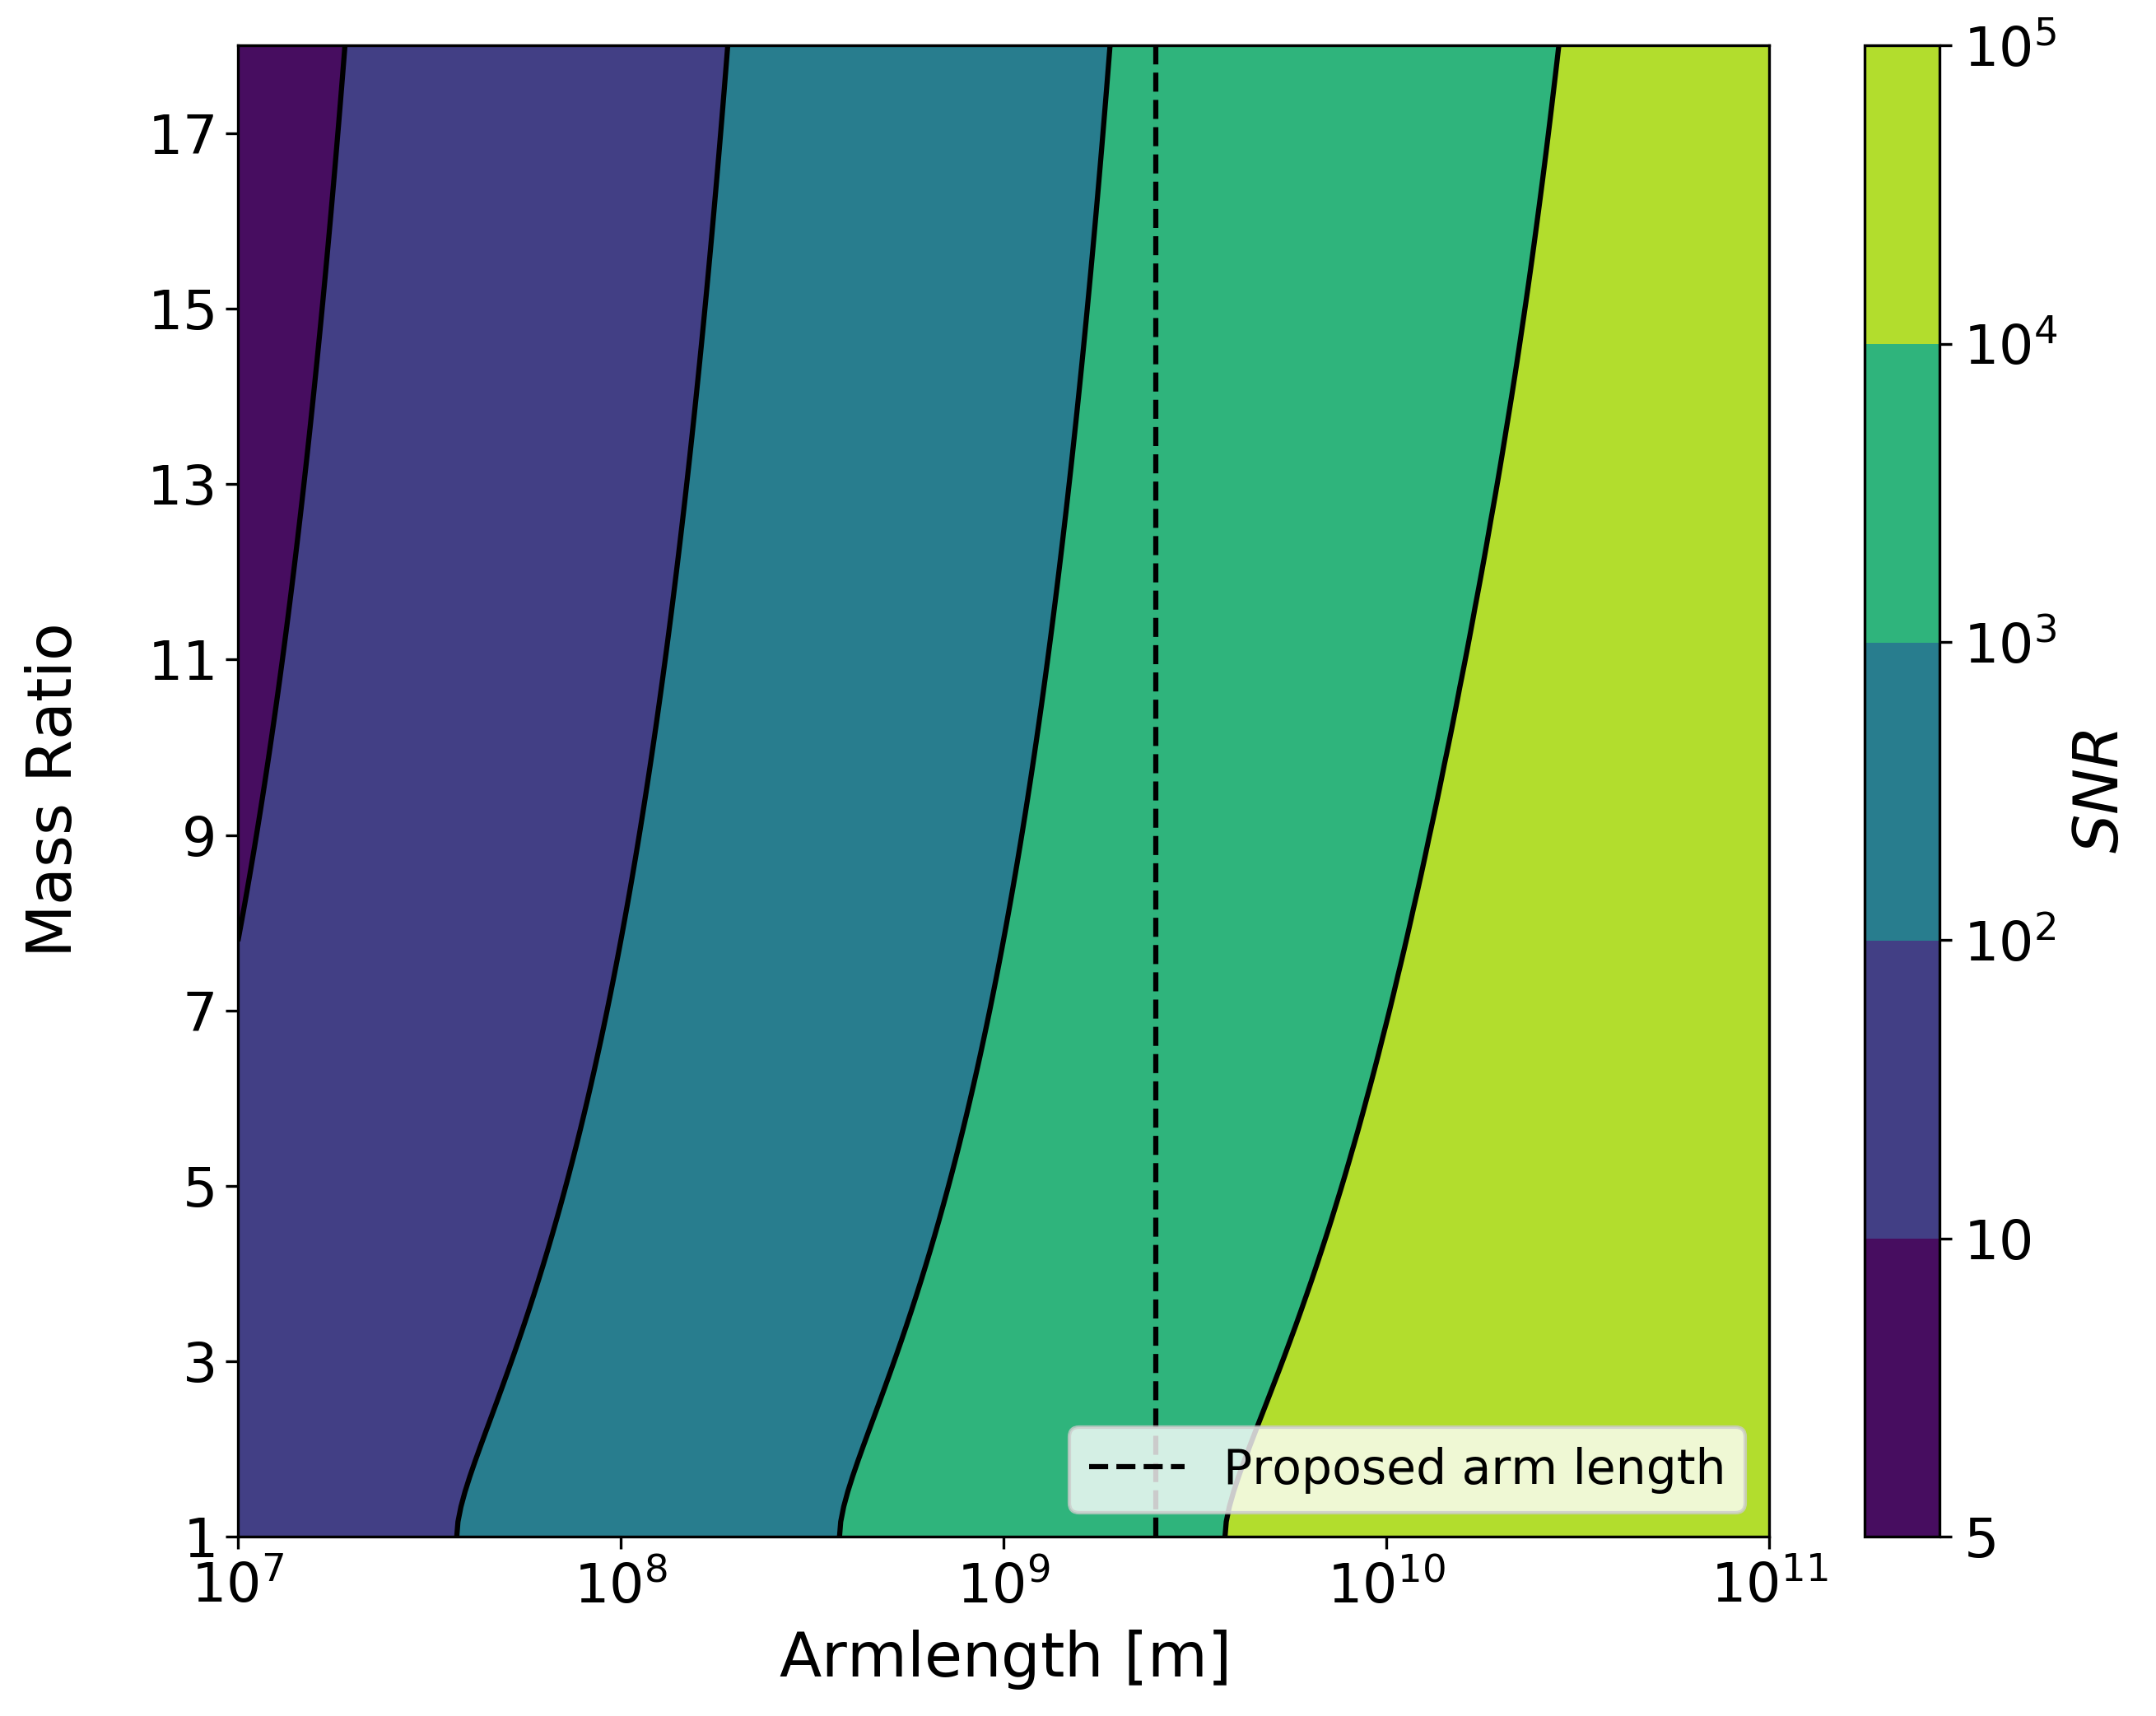

Model:  LISA_ESA_L_vs_q ,  done. t = :  138.541898727417


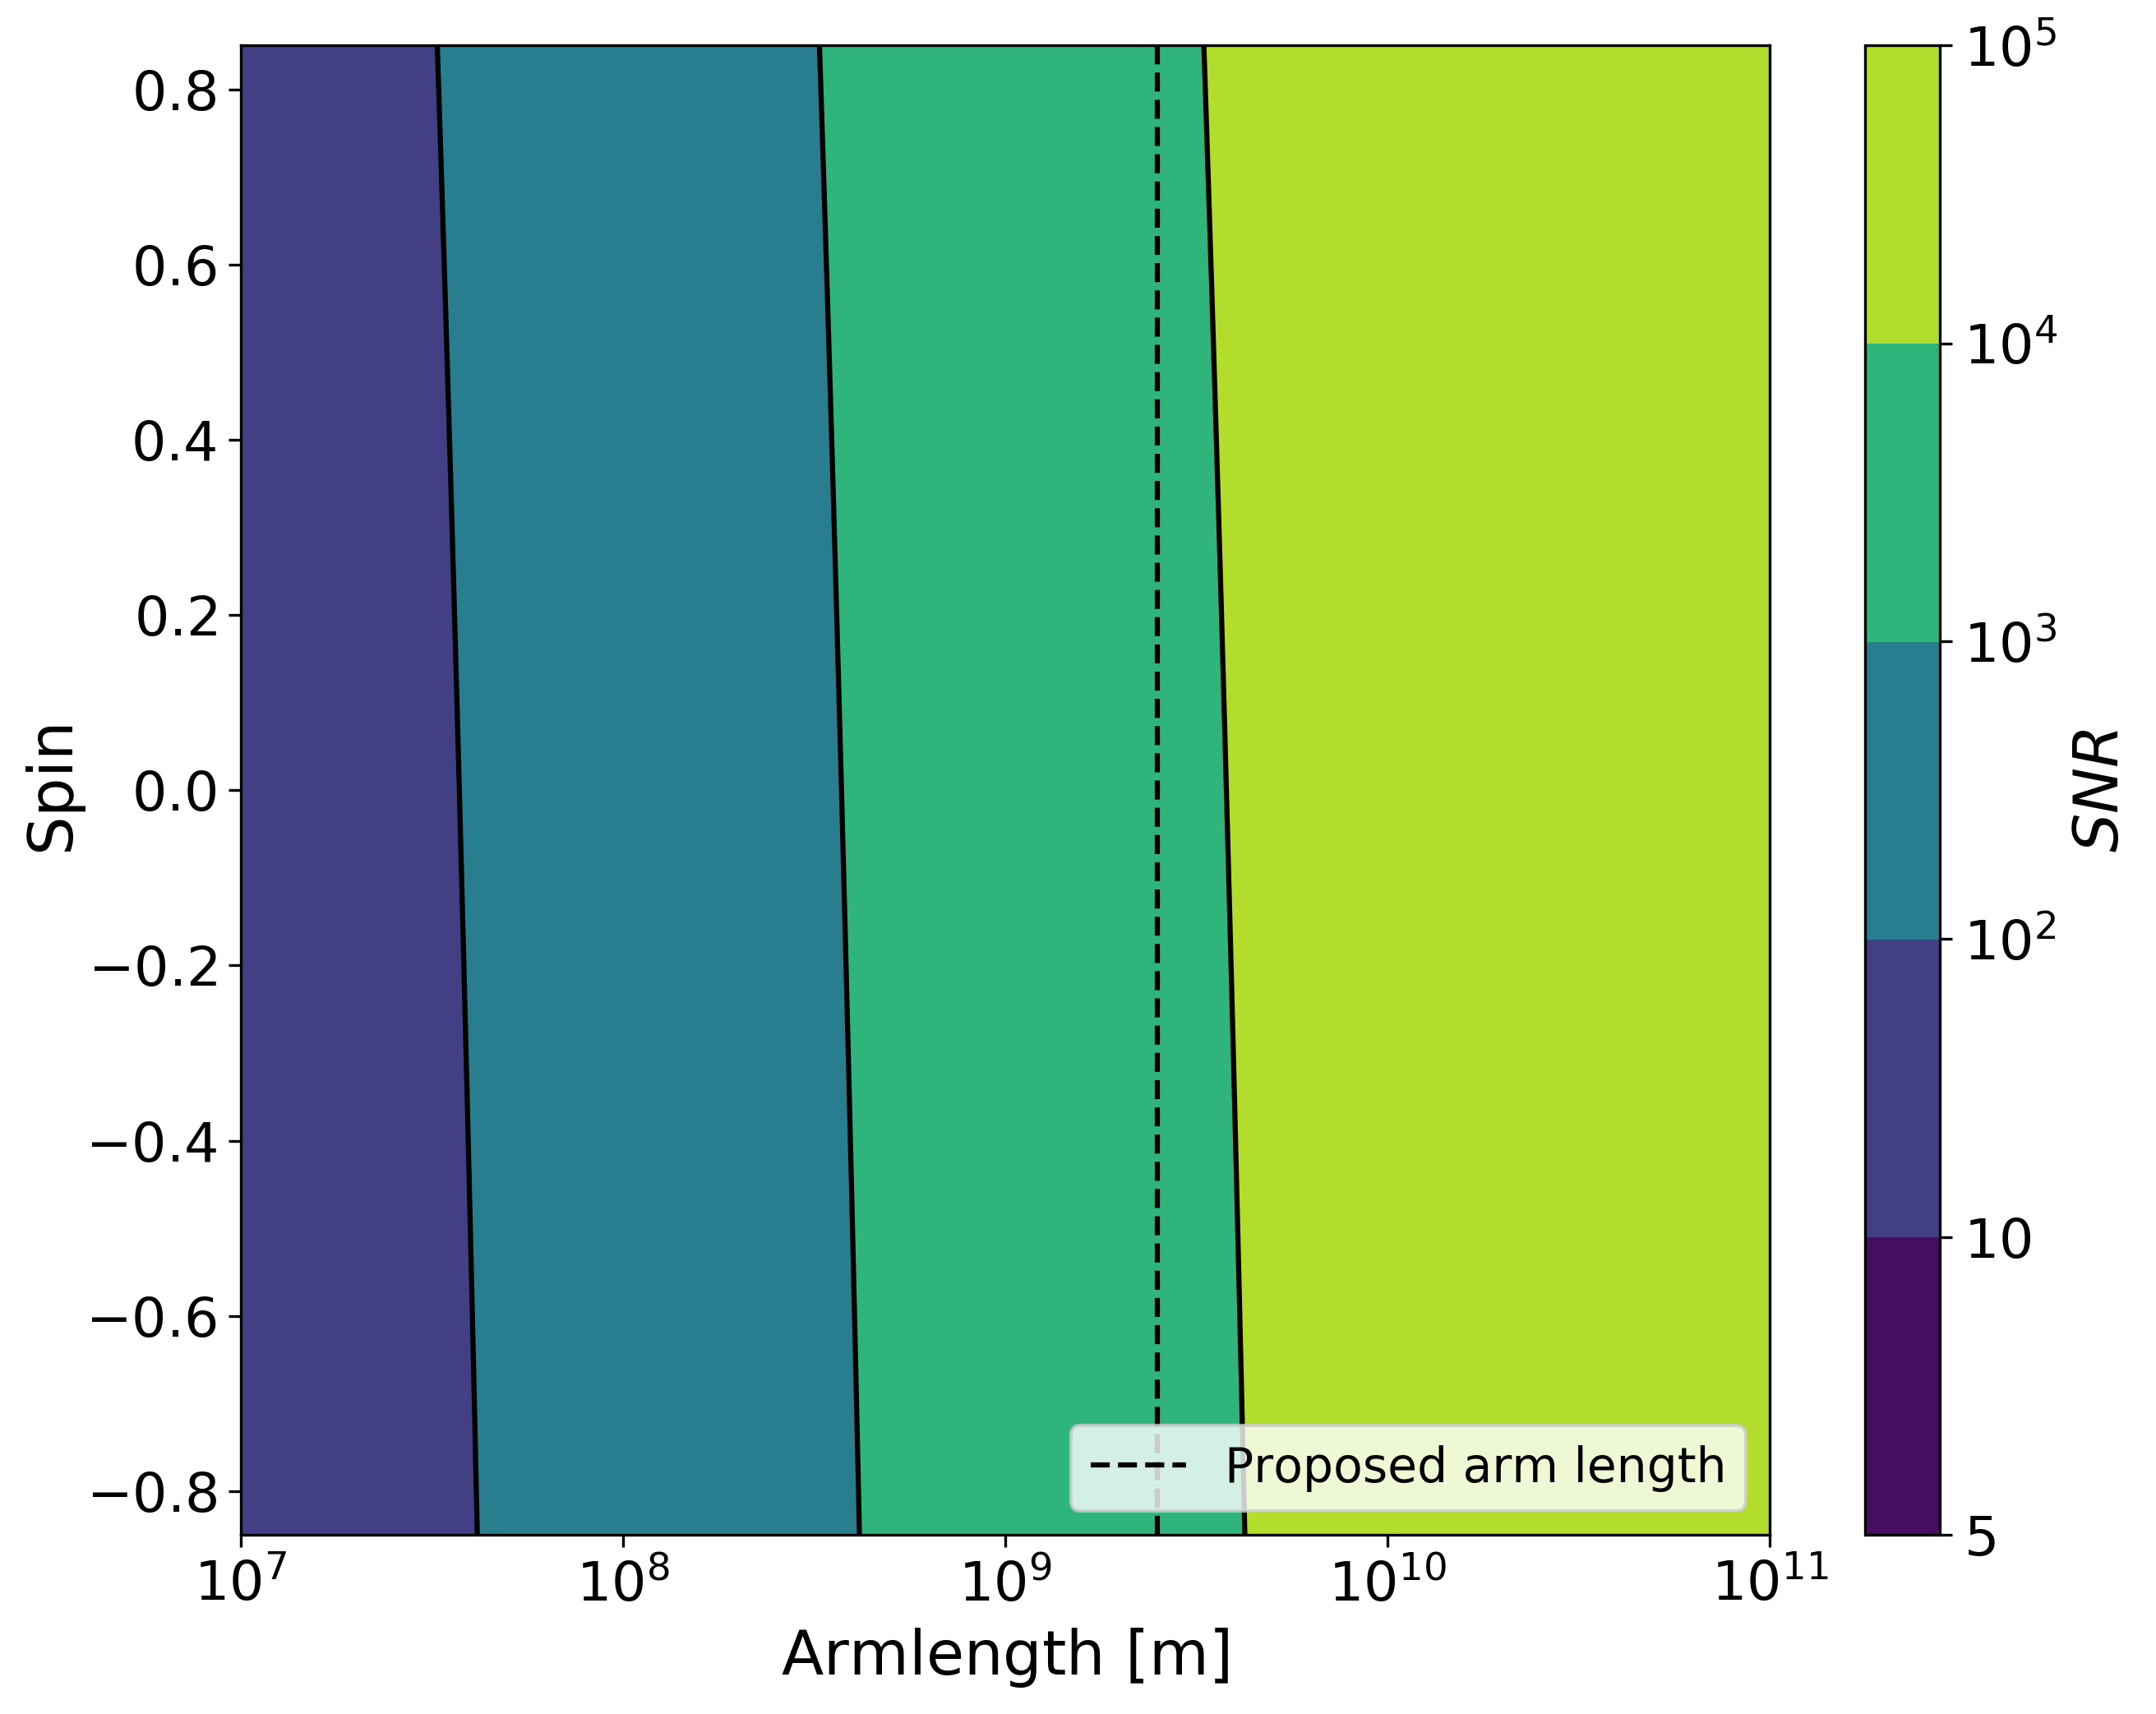

Model:  LISA_ESA_L_vs_chi1 ,  done. t = :  149.18875980377197


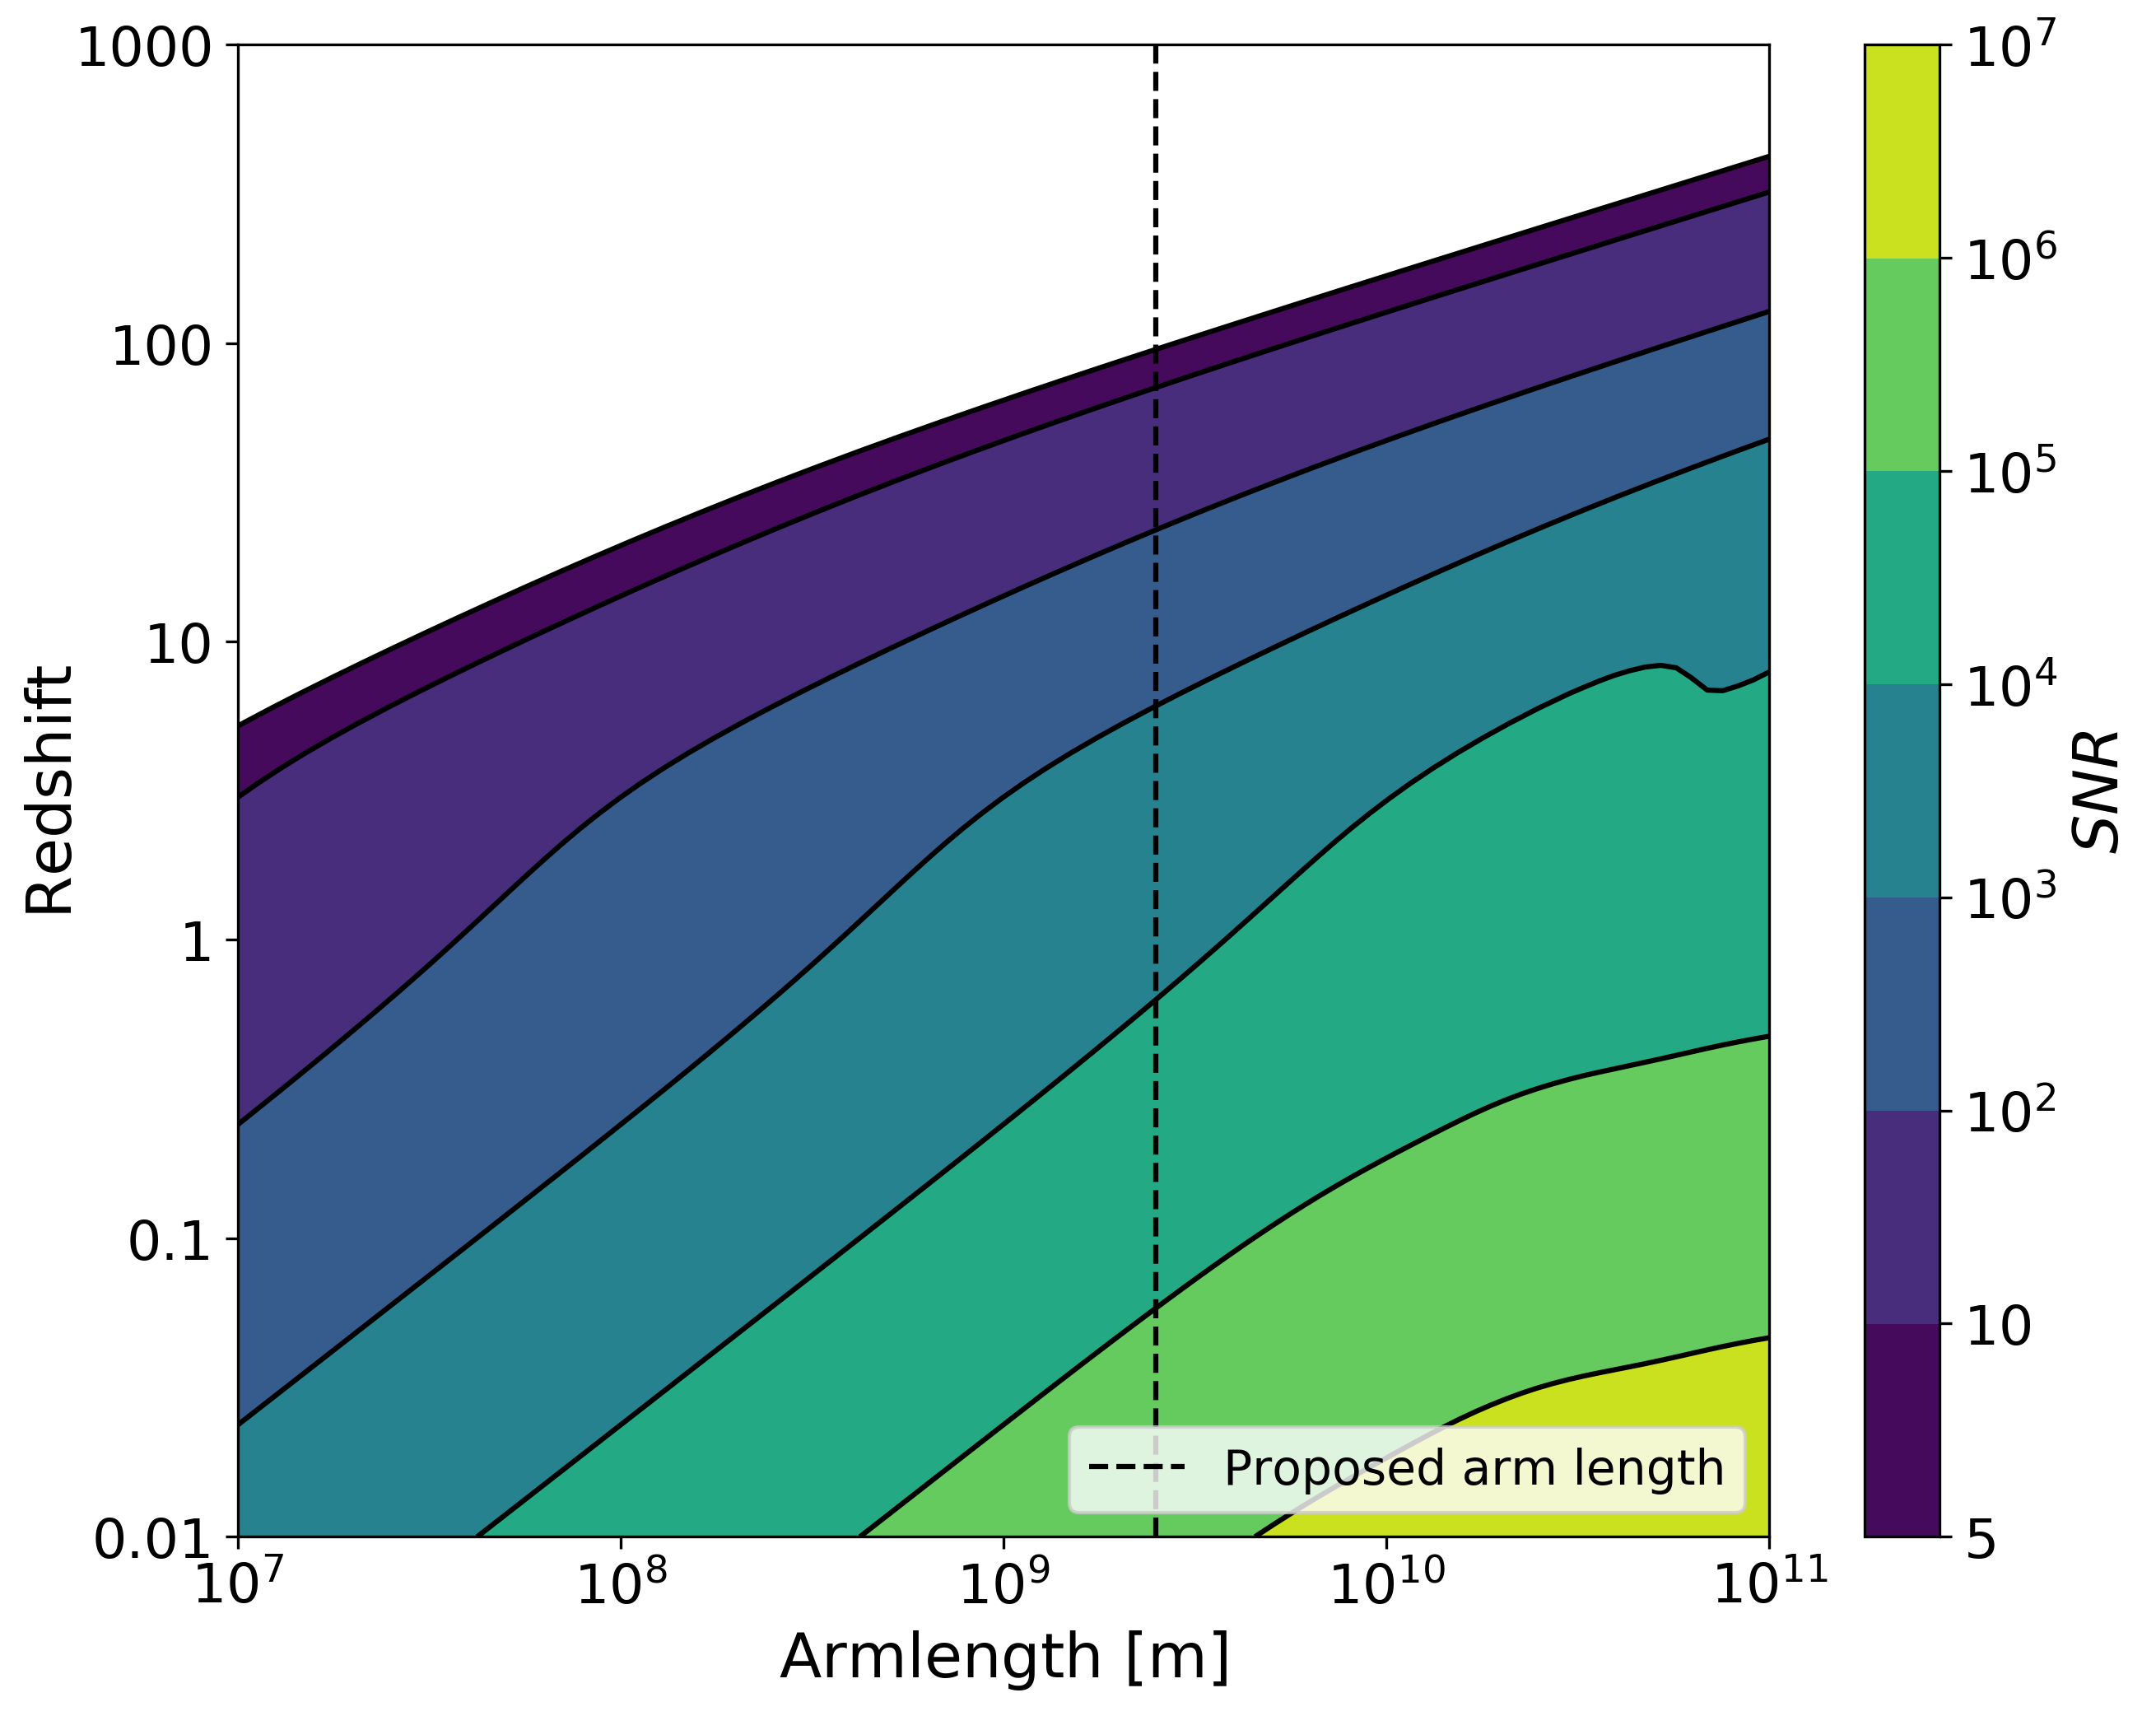

Model:  LISA_ESA_L_vs_z ,  done. t = :  125.8050057888031


In [31]:
for model in models:
    for var_y in var_ys:
        instrument = Get_Instrument(model)
        source = Get_Source(model)
        #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '.png'
        save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_SNR_v2.txt'
        save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_v2.txt'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)
        
        print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

In [16]:
#Number of SNRMatrix rows
sampleRate_y = 100
#Number of SNRMatrix columns
sampleRate_x = 100
#Variable on y-axis
var_ys = ['q','chi1','z','Infrastructure Length','Seismic Gamma','Laser Power']
#Variable on x-axis
var_x = 'M'
#models = range(13)
models = [1,2,3]

In [25]:
for model in models:
    for var_y in var_ys:
        instrument = Get_Instrument(model)
        source = Get_Source(model)
        #figloc = save_fig_location + 'SNR_' + instrument.name + '_' + var_y + '.png'
        save_snr_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_SNR_v2.txt'
        save_sample_name = instrument.name + '_' + var_x + '_vs_' + var_y + '_samples_v2.txt'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_snr_location,save_snr_name,save_sample_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)

        print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

AttributeError: 'GroundBased' object has no attribute '_fT'